# set working directory

In [1]:
import os

import hydra
import omegaconf
import pyrootutils

root = pyrootutils.setup_root(os.path.abspath("inherently_interpretable_model.ipynb"), pythonpath=True)
import os

os.chdir(root)

# set python path

In [2]:
import sys

sys.path.append(str(root / "src"))

# import packages

In [3]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import tqdm
from scipy.special import softmax
from scipy.stats import norm, pearsonr
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from torchvision import models, transforms

import clip
from MONET.datamodules.multiplex_datamodule import MultiplexDatamodule
from MONET.utils.loader import custom_collate_per_key, dataloader_apply_func
from MONET.utils.static import (
    concept_to_prompt,
    fitzpatrick17k_disease_label,
    fitzpatrick17k_ninelabel,
    fitzpatrick17k_threelabel,
    skincon_cols,
)
from MONET.utils.text_processing import generate_prompt_token_from_concept
from MONET.utils.io import load_pkl
from PIL import Image

In [4]:
def wandb_to_exppath(wandb, log_path="/gscratch/cse/chanwkim/MONET_log/train/runs"):
    log_path = Path(log_path)
    for experiment in os.listdir(log_path):
        if os.path.exists(log_path / experiment / "wandb"):
            filenames = os.listdir(log_path / experiment / "wandb")
            filename = [filename for filename in filenames if filename.startswith("run")][0][-8:]
            if filename == wandb:
                return log_path / experiment
    raise RuntimeError("not found")


# exppath = wandb_to_exppath(
#     wandb="15eh81uv", log_path="/projects/leelab2/chanwkim/dermatology_datasets/logs/train/runs"
# )
# print([exppath / "checkpoints" / ckpt for ckpt in os.listdir(exppath / "checkpoints/")])

In [5]:
log_dir = Path("logs")

In [6]:
!gpustat

l0.cs.washington.edu           Tue Oct 10 01:26:57 2023  525.89.02
[0] NVIDIA GeForce RTX 2080 Ti | 24'C,   0 % |   255 / 11264 MB |
[1] NVIDIA GeForce RTX 2080 Ti | 25'C,   0 % |   255 / 11264 MB |
[2] NVIDIA GeForce RTX 2080 Ti | 24'C,   0 % |   255 / 11264 MB |
[3] NVIDIA GeForce RTX 2080 Ti | 24'C,   0 % |   255 / 11264 MB |
[4] NVIDIA GeForce RTX 2080 Ti | 40'C,   0 % |  4815 / 11264 MB | chanwkim(4560M)
[5] NVIDIA GeForce RTX 2080 Ti | 38'C,   0 % |  4815 / 11264 MB | chanwkim(4560M)
[6] NVIDIA GeForce RTX 2080 Ti | 39'C,   8 % |  4815 / 11264 MB | chanwkim(4560M)
[7] NVIDIA GeForce RTX 2080 Ti | 26'C,   0 % |   255 / 11264 MB |


# Initialize Model

In [7]:
model_name = "zt0n2xd0"
model_device = "cuda:7"

cfg_model = omegaconf.OmegaConf.load(root / "configs" / "model" / "contrastive.yaml")
cfg_model.net.model_name_or_path = "ViT-L/14"
cfg_model.net.device = model_device
cfg_model

model = hydra.utils.instantiate(cfg_model)
model.to(model_device)
model.eval()

ContrastiveLitModule(
  (net): ImageTextEncoder(
    (model): CLIP(
      (visual): VisionTransformer(
        (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (transformer): Transformer(
          (resblocks): Sequential(
            (0): ResidualAttentionBlock(
              (attn): MultiheadAttention(
                (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
              )
              (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
              (mlp): Sequential(
                (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
                (gelu): QuickGELU()
                (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
              )
              (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            )
            (1): ResidualAttentionBlock(
        

In [8]:
model_path_dir = {
    "zt0n2xd0": "/projects/leelab2/chanwkim/dermatology_datasets/logs/train/runs/2023-01-17_20-58-15/checkpoints/last.ckpt",
}

if model_name != "ViT-L/14":
    model_path = model_path_dir[model_name]
    loaded = torch.load(model_path, map_location=model_device)
    model.load_state_dict(loaded["state_dict"])
    print('loaded')

loaded


In [9]:
model_name = "zt0n2xd0"
model_device = "cuda:7"

cfg_model = omegaconf.OmegaConf.load(root / "configs" / "model" / "contrastive.yaml")
cfg_model.net.model_name_or_path = "ViT-L/14"
cfg_model.net.device = model_device
cfg_model

model_vanilla = hydra.utils.instantiate(cfg_model)
model_vanilla.to(model_device)
model_vanilla.eval()

ContrastiveLitModule(
  (net): ImageTextEncoder(
    (model): CLIP(
      (visual): VisionTransformer(
        (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (transformer): Transformer(
          (resblocks): Sequential(
            (0): ResidualAttentionBlock(
              (attn): MultiheadAttention(
                (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
              )
              (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
              (mlp): Sequential(
                (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
                (gelu): QuickGELU()
                (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
              )
              (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            )
            (1): ResidualAttentionBlock(
        

In [10]:
variable_dict={}

In [11]:
def setup_dataloader(dataset_name):    
    if dataset_name=="clinical_fd_clean_nodup_nooverlap":
        cfg_dm = omegaconf.OmegaConf.load(root / "configs" / "datamodule" / "multiplex.yaml")
        # cfg.data_dir="/scr/chanwkim/dermatology_datasets"
        cfg_dm.data_dir = "/sdata/chanwkim/dermatology_datasets"
        cfg_dm.dataset_name_test = "clinical_fd_clean_nodup_nooverlap=all"
        cfg_dm.split_seed = 42

        dm = hydra.utils.instantiate(cfg_dm)
        dm.setup()     
        
        dataloader = dm.test_dataloader()  
        
    elif dataset_name=="derm7pt_derm_nodup":
        cfg_dm = omegaconf.OmegaConf.load(root / "configs" / "datamodule" / "multiplex.yaml")
        # cfg.data_dir="/scr/chanwkim/dermatology_datasets"
        cfg_dm.data_dir = "/sdata/chanwkim/dermatology_datasets"
        cfg_dm.dataset_name_test = "derm7pt_derm_nodup=all"
        cfg_dm.split_seed = 42

        dm = hydra.utils.instantiate(cfg_dm)
        dm.setup()     
        
        dataloader = dm.test_dataloader()    
        
    elif dataset_name=="derm7pt_clinical_nodup":
        cfg_dm = omegaconf.OmegaConf.load(root / "configs" / "datamodule" / "multiplex.yaml")
        # cfg.data_dir="/scr/chanwkim/dermatology_datasets"
        cfg_dm.data_dir = "/sdata/chanwkim/dermatology_datasets"
        cfg_dm.dataset_name_test = "derm7pt_clinical_nodup=all"
        cfg_dm.split_seed = 42

        dm = hydra.utils.instantiate(cfg_dm)
        dm.setup()     
        
        dataloader = dm.test_dataloader()   
        
    elif dataset_name=="derm7pt":
        cfg_dm = omegaconf.OmegaConf.load(root / "configs" / "datamodule" / "multiplex.yaml")
        # cfg.data_dir="/scr/chanwkim/dermatology_datasets"
        cfg_dm.data_dir = "/sdata/chanwkim/dermatology_datasets"
        cfg_dm.dataset_name_test = "derm7pt=all"
        cfg_dm.split_seed = 42

        dm = hydra.utils.instantiate(cfg_dm)
        dm.setup()     
        
        dataloader = dm.test_dataloader()
        
    elif dataset_name=="allpubmedtextbook":
        cfg_dm = omegaconf.OmegaConf.load(root / "configs" / "datamodule" / "multiplex.yaml")
        # cfg.data_dir="/scr/chanwkim/dermatology_datasets"
        cfg_dm.data_dir = "/sdata/chanwkim/dermatology_datasets"
        cfg_dm.dataset_name_test = "pubmed=all,textbook=all"
        cfg_dm.split_seed = 42

        dm = hydra.utils.instantiate(cfg_dm)
        dm.setup()
        
        dataloader = dm.test_dataloader()          
    
    elif dataset_name=="isic_nodup_nooverlap":
        cfg_dm = omegaconf.OmegaConf.load(root / "configs" / "datamodule" / "multiplex.yaml")
        # cfg.data_dir="/scr/chanwkim/dermatology_datasets"
        cfg_dm.data_dir = "/sdata/chanwkim/dermatology_datasets"
        cfg_dm.dataset_name_test = "isic_nodup_nooverlap=all"
        cfg_dm.split_seed = 42

        dm = hydra.utils.instantiate(cfg_dm)
        dm.setup()     
        
        dataloader = dm.test_dataloader()    
        
    return {"dataloader": dataloader}

In [12]:
for dataset_name in ["clinical_fd_clean_nodup_nooverlap", "derm7pt_derm_nodup",
                     "isic_nodup_nooverlap", 
                    ]:
    variable_dict.setdefault(dataset_name, {})
    variable_dict[dataset_name].update(setup_dataloader(dataset_name))

Loading pickle file without filtering...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 16577/16577 [00:00<00:00, 1868807.35it/s]


Loading pickle file without filtering...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 656/656 [00:00<00:00, 1740331.07it/s]

Before removing duplicates (4951, 60)
After removing duplicates (4386, 60)
Before removing training overlap (4386, 60)
After removing training overlap (4336, 60)


Loaded clinical_fd_clean_nodup_nooverlap dataset. train: 3993, val: 999, test: 999 all: 4992
Loading pickle file without filtering...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 16577/16577 [00:00<00:00, 1862399.95it/s]


Loaded fitzpatrick17k dataset. train: 13261, val: 3316, test: 3316 all: 16577
Loading pickle file without filtering...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 51555/51555 [00:00<00:00, 1319107.55it/s]


Loaded pubmed dataset. train: 40205, val: 10060, test: 10060 all: 50131
Loading pickle file without filtering...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2013/2013 [00:00<00:00, 1789557.85it/s]


Before removing duplicates (2013, 18)
After removing duplicates (2012, 18)
Loaded derm7pt_derm_nodup dataset. train: 808, val: 203, test: 203 all: 1011
Loading pickle file without filtering...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 16577/16577 [00:00<00:00, 1739398.53it/s]


Loaded fitzpatrick17k dataset. train: 13261, val: 3316, test: 3316 all: 16577
Loading pickle file without filtering...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 51555/51555 [00:00<00:00, 1332470.70it/s]


Loaded pubmed dataset. train: 40205, val: 10060, test: 10060 all: 50131
Loading pickle file without filtering...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 16577/16577 [00:00<00:00, 1825626.29it/s]


Loaded fitzpatrick17k dataset. train: 13261, val: 3316, test: 3316 all: 16577
Loading pickle file without filtering...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 71670/71670 [00:00<00:00, 1360250.18it/s]
/homes/gws/chanwkim/MONET_revision/src/MONET/datamodules/setup_dataset.py:1247: DtypeWarning: Columns (8,11,13,14,15,17,18,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  text_df = pd.read_csv(Path(data_dir) / "final_metadata_all.csv").set_index(


Before removing duplicates (71634, 47)
After removing duplicates (70660, 47)
Before removing training overlap (70660, 47)
After removing training overlap (70654, 47)
Loaded isic_nodup_nooverlap dataset. train: 56523, val: 14131, test: 14131 all: 70654
Loading pickle file without filtering...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 51555/51555 [00:00<00:00, 1271296.37it/s]


Loaded pubmed dataset. train: 40205, val: 10060, test: 10060 all: 50131


In [13]:
def batch_func(batch):
    with torch.no_grad():
        batch["image"] = batch["image"].to(model_device)
        image_features = model.model_step_with_image(batch)["image_features"]
        image_features_vanilla = model_vanilla.model_step_with_image(batch)["image_features"]
    # print(batch["metadata"])
    return {
        "image_features": image_features.detach().cpu(),
        "image_features_vanilla": image_features_vanilla.detach().cpu(),
        "metadata": batch["metadata"],
    }

def setup_features(dataset_name, dataloader):
    if dataset_name=="isic_nodup_nooverlap":
        loader_applied = torch.load(log_dir/"image_features"/"isic_nodup_nooverlap.pt", map_location="cpu")
        image_features = loader_applied["image_features"].cpu()
        metadata_all = loader_applied["metadata_all"]
        
        loader_applied2 = torch.load(log_dir/"image_features"/"isic_nodup_nooverlap_vanilla.pt", map_location="cpu")
        image_features_vanilla = loader_applied2["image_features_vanilla"].cpu()
        metadata_all_vanilla = loader_applied2["metadata_all"]  
        
        assert np.all(metadata_all.index==metadata_all_vanilla.index)

        return {"image_features":image_features, 
                "image_features_vanilla":image_features_vanilla,
                "metadata_all": metadata_all}
    
    else:
        loader_applied = dataloader_apply_func(
            dataloader=dataloader,
            func=batch_func,
            collate_fn=custom_collate_per_key,
        )
        image_features = loader_applied["image_features"].cpu()
        image_features_vanilla = loader_applied["image_features_vanilla"].cpu()
        metadata_all = loader_applied["metadata"]

        return {"image_features":image_features, 
                "image_features_vanilla":image_features_vanilla,
                "metadata_all": metadata_all}

# def setup_features(dataset_name, dataloader):

#     loader_applied = dataloader_apply_func(
#         dataloader=dataloader,
#         func=batch_func,
#         collate_fn=custom_collate_per_key,
#     )
#     image_features = loader_applied["image_features"].cpu()
#     image_features_vanilla = loader_applied["image_features_vanilla"].cpu()
#     metadata_all = loader_applied["metadata"]

#     return {"image_features":image_features, 
#             "image_features_vanilla":image_features_vanilla,
#             "metadata_all": metadata_all}
for dataset_name in ["clinical_fd_clean_nodup_nooverlap", "derm7pt_derm_nodup",
                     "isic_nodup_nooverlap", 
                    ]:
    print(dataset_name)
    variable_dict[dataset_name].update(setup_features(dataset_name, variable_dict[dataset_name]["dataloader"])) 

clinical_fd_clean_nodup_nooverlap


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [01:02<00:00,  1.61s/it]


derm7pt_derm_nodup


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:15<00:00,  1.90s/it]


isic_nodup_nooverlap


In [14]:
def normalize_embedding(dataset_name, image_features):
    #prompt_ref_tokenized = clip.tokenize(prompt_ref, truncate=True)
    #output = model.model_step_with_text({"text": prompt_ref_tokenized.to(model_device)})
    #prompt_ref_embedding=output["text_features"].detach().cpu()
    #prompt_ref_embedding_norm=prompt_ref_embedding/prompt_ref_embedding.norm(dim=1, keepdim=True)      
    
    image_features_norm = image_features / image_features.norm(dim=1, keepdim=True)
    
    return {"image_features_norm": image_features_norm}    

In [15]:
for dataset_name in ["clinical_fd_clean_nodup_nooverlap", "derm7pt_derm_nodup",
                     "isic_nodup_nooverlap", 
                    ]:
    variable_dict[dataset_name].update(
        {"image_features_vanilla_norm":normalize_embedding(dataset_name, 
                        variable_dict[dataset_name]["image_features_vanilla"])["image_features_norm"]}
    )           
    variable_dict[dataset_name].update(
        {"image_features_norm":normalize_embedding(dataset_name, 
                        variable_dict[dataset_name]["image_features"])["image_features_norm"]}
    )  
#     variable_dict[dataset_name].update(
#         {"image_features_vanilla_norm":normalize_embedding(dataset_name, 
#                         variable_dict[dataset_name]["image_features_vanilla"])["image_features_norm"]}
#     )    

In [16]:
variable_dict[dataset_name].keys()

dict_keys(['dataloader', 'image_features', 'image_features_vanilla', 'metadata_all', 'image_features_vanilla_norm', 'image_features_norm'])

In [17]:
isic_diagnosis_malignant_mapping=\
{'AIMP':'indeterminate',
'acrochordon':'benign',
'actinic keratosis':'benign', # 
'angiofibroma or fibrous papule':'benign', 
'angiokeratoma':'benign',
'angioma':'benign',
'atypical melanocytic proliferation':'indeterminate',
'atypical spitz tumor':'indeterminate', #
'basal cell carcinoma':'malignant', #
'cafe-au-lait macule':'benign',
'clear cell acanthoma':'benign',
'dermatofibroma':'benign', #
'lentigo NOS':'benign',
'lentigo simplex':'benign',
'lichenoid keratosis':'benign',
'melanoma':'malignant',
'melanoma metastasis':'malignant',
'neurofibroma':'benign',
'nevus':'benign',
'other':'indeterminate',
'pigmented benign keratosis':'benign', #??
'scar':'benign',
'seborrheic keratosis':'benign',
'solar lentigo':'benign',
'squamous cell carcinoma':'malignant',
'vascular lesion':'benign', # 
'verruca':'benign'
}

def isic_map_diagnosis_malignant(diagnosis, benign_malignant):
#     if diagnosis=="basal cell carcinoma":
#         print(diagnosis_malignant_mapping[diagnosis], benign_malignant)    
    if isinstance(benign_malignant, str):
        return benign_malignant
    elif diagnosis in isic_diagnosis_malignant_mapping.keys():
        return isic_diagnosis_malignant_mapping[diagnosis]
    elif np.isnan(diagnosis):
        return "indeterminate"
    else:
        raise RuntimeError

In [18]:
derm7pt_diagnosis_malignant_mapping=\
{   'basal cell carcinoma':'malignant', 
    'blue nevus': 'benign', #
    'clark nevus':'benign', # 
    'combined nevus': 'benign', #
    'congenital nevus': 'benign', #
    'dermal nevus': 'benign', 
    'dermatofibroma':'benign', 
    'lentigo': 'benign',
    'melanoma (in situ)': 'malignant',
    'melanoma (less than 0.76 mm)': 'malignant',
    'melanoma (0.76 to 1.5 mm)': 'malignant',
    'melanoma (more than 1.5 mm)': 'malignant',
    'melanoma metastasis': 'malignant',
    'melanosis': 'benign',# 
    'miscellaneous': 'unknown', #
    'recurrent nevus': 'benign', #
    'reed or spitz nevus': 'benign', #
    'seborrheic keratosis':'benign',
    'vascular lesion': 'benign', 
    'melanoma': 'malignant',
}

def derm7pt_map_diagnosis_malignant(diagnosis):
#     if diagnosis=="basal cell carcinoma":
#         print(diagnosis_malignant_mapping[diagnosis], benign_malignant)    
    if diagnosis in derm7pt_diagnosis_malignant_mapping.keys():
        return derm7pt_diagnosis_malignant_mapping[diagnosis]
    elif np.isnan(diagnosis):
        return "indeterminate"
    else:
        raise RuntimeError

In [19]:
ddi_map = {
    "acral-melanotic-macule": "melanoma look-alike",
    "atypical-spindle-cell-nevus-of-reed": "melanoma look-alike",
    "benign-keratosis": "melanoma look-alike",
    "blue-nevus": "melanoma look-alike",
    "dermatofibroma": "melanoma look-alike",
    "dysplastic-nevus": "melanoma look-alike",
    "epidermal-nevus": "melanoma look-alike",
    "hyperpigmentation": "melanoma look-alike",
    "keloid": "melanoma look-alike",
    "inverted-follicular-keratosis": "melanoma look-alike",
    "melanocytic-nevi": "melanoma look-alike",
    "melanoma": "melanoma",
    "melanoma-acral-lentiginous": "melanoma",
    "melanoma-in-situ": "melanoma",
    "nevus-lipomatosus-superficialis": "melanoma look-alike",
    "nodular-melanoma-(nm)": "melanoma",
    "pigmented-spindle-cell-nevus-of-reed": "melanoma look-alike",
    "seborrheic-keratosis": "melanoma look-alike",
    "seborrheic-keratosis-irritated": "melanoma look-alike",
    "solar-lentigo": "melanoma look-alike",
}

In [20]:
ddi_map.keys()

dict_keys(['acral-melanotic-macule', 'atypical-spindle-cell-nevus-of-reed', 'benign-keratosis', 'blue-nevus', 'dermatofibroma', 'dysplastic-nevus', 'epidermal-nevus', 'hyperpigmentation', 'keloid', 'inverted-follicular-keratosis', 'melanocytic-nevi', 'melanoma', 'melanoma-acral-lentiginous', 'melanoma-in-situ', 'nevus-lipomatosus-superficialis', 'nodular-melanoma-(nm)', 'pigmented-spindle-cell-nevus-of-reed', 'seborrheic-keratosis', 'seborrheic-keratosis-irritated', 'solar-lentigo'])

In [21]:
normal_skin=['clean', "smooth", 'Healthy', 'normal', 'soft', 'flat']
concept_reference_dict = {
    "Asymmetry": ["Symmetry", "Regular", "Uniform"],
    "Irregular": ["Regular", "Smooth"],
    "Black": ["White", "Creamy", "Colorless", "Unpigmented"],
    "Blue": ["Green", "Red"],
    "White": ["Black", "Colored", "Pigmented"],
    "Brown": ["Pale", "White"],
    "Erosion":["Deposition", "Buildup"],
    "Multiple Colors": ["Single Color", "Unicolor"],
    "Tiny": ["Large", "Big"],
    "Regular": ["Irregular"],  
}

concept_reference_dict.update({
    'derm7ptconcept_pigment network':['clean', 'smooth', 'Healthy', 'normal', 'soft', 'flat'],
    'derm7ptconcept_regression structure':['clean', 'smooth', 'Healthy', 'normal', 'soft', 'flat'],
    'derm7ptconcept_pigmentation':['clean', 'smooth', 'Healthy', 'normal', 'soft', 'flat'],
    'derm7ptconcept_blue whitish veil':['clean', 'smooth', 'Healthy', 'normal', 'soft', 'flat'],
    'derm7ptconcept_vascular structures':['clean', 'smooth', 'Healthy', 'normal', 'soft', 'flat'],
    'derm7ptconcept_streaks':['clean', 'smooth', 'Healthy', 'normal', 'soft', 'flat'],
    'derm7ptconcept_dots and globules':['clean', 'smooth', 'Healthy', 'normal', 'soft', 'flat'],
})


    
for concept_name in skincon_cols:    
    if concept_name=="skincon_Patch":
        negative_terms=["Spotted"]    
    elif concept_name == "skincon_Exudate":
        negative_terms = ["Absence"]
    elif concept_name == "skincon_Xerosis":
        negative_terms = ["Moisturized"]
    elif concept_name == "skincon_Warty/Papillomatous":
        negative_terms = ["Smooth"]
    elif concept_name == "skincon_Dome-shaped":
        negative_terms = ["Flat"]
    elif concept_name == "skincon_Brown(Hyperpigmentation)":
        negative_terms = ["Hypopigmentation"]
    elif concept_name == "skincon_Translucent":
        negative_terms = ["Opaque"]
    elif concept_name == "skincon_White(Hypopigmentation)":
        negative_terms = ["Hyperpigmentation"]
    elif concept_name == "skincon_Purple":
        negative_terms = ["Yellow"]
    elif concept_name == "skincon_Yellow":
        negative_terms = ["Purple"]
    elif concept_name == "skincon_Black":
        negative_terms = ["White", "Creamy", "Colorless", "Unpigmented"]
    elif concept_name == "skincon_Lichenification":
        negative_terms = ["Softening"]
    elif concept_name == "skincon_Blue":
        negative_terms = ["Orange"]
    elif concept_name == "skincon_Gray":
        negative_terms = ["Colorful"]
    else:
        negative_terms = ['clean', 'smooth', 'Healthy', 'normal', 'soft', 'flat']
        
    concept_reference_dict[concept_name]=negative_terms
    


# print()
# for key in concept_reference_dict.keys():
#     print(f"{key}: {concept_reference_dict[key]}")

concept_reference_dict_={}
for key,value in concept_reference_dict.items():
    concept_reference_dict_[key if ("skincon_" in key) or ("derm7ptconcept_" in key) else f"cbm_{key}"]=\
    [value if ("skincon_" in v) or ("derm7ptconcept_" in v) else f"cbm_{v}" for v in value]
concept_reference_dict=concept_reference_dict_;del concept_reference_dict_

# concept_reference_dict["red"]=["cbm_White",  "cbm_Colorless", "cbm_Unpigmented"]

print()
for key in concept_reference_dict.keys():
    print(f"{key}: {concept_reference_dict[key]}")


cbm_Asymmetry: ['cbm_Symmetry', 'cbm_Regular', 'cbm_Uniform']
cbm_Irregular: ['cbm_Regular', 'cbm_Smooth']
cbm_Black: ['cbm_White', 'cbm_Creamy', 'cbm_Colorless', 'cbm_Unpigmented']
cbm_Blue: ['cbm_Green', 'cbm_Red']
cbm_White: ['cbm_Black', 'cbm_Colored', 'cbm_Pigmented']
cbm_Brown: ['cbm_Pale', 'cbm_White']
cbm_Erosion: ['cbm_Deposition', 'cbm_Buildup']
cbm_Multiple Colors: ['cbm_Single Color', 'cbm_Unicolor']
cbm_Tiny: ['cbm_Large', 'cbm_Big']
cbm_Regular: ['cbm_Irregular']
derm7ptconcept_pigment network: ['cbm_clean', 'cbm_smooth', 'cbm_Healthy', 'cbm_normal', 'cbm_soft', 'cbm_flat']
derm7ptconcept_regression structure: ['cbm_clean', 'cbm_smooth', 'cbm_Healthy', 'cbm_normal', 'cbm_soft', 'cbm_flat']
derm7ptconcept_pigmentation: ['cbm_clean', 'cbm_smooth', 'cbm_Healthy', 'cbm_normal', 'cbm_soft', 'cbm_flat']
derm7ptconcept_blue whitish veil: ['cbm_clean', 'cbm_smooth', 'cbm_Healthy', 'cbm_normal', 'cbm_soft', 'cbm_flat']
derm7ptconcept_vascular structures: ['cbm_clean', 'cbm_smooth

In [72]:
def set_config(dataset_name, metadata_all):
    if "clinical_fd_clean" in dataset_name:
        y_pos_malignant=(((metadata_all["source"]=="fitz")&(metadata_all["three_partition_label"]=="malignant"))|
              ((metadata_all["source"]=="ddi")&(metadata_all["malignant"] == True))).values
        
        y_pos_melanoma=(((metadata_all["source"]=="fitz")&(metadata_all["nine_partition_label"]=="malignant melanoma"))|
              (metadata_all.apply(lambda x: (ddi_map[x["disease"]]=="melanoma") if (x["source"]=="ddi" and x["disease"] in ddi_map.keys()) else False, axis=1))).values
        
        valid_idx_malignant=(metadata_all["skincon_Do not consider this image"]!=1).values
        valid_idx_melanoma=((metadata_all["skincon_Do not consider this image"]!=1)&\
                          (
                            ((metadata_all["source"]=="fitz")&((metadata_all["nine_partition_label"]=='malignant melanoma')|
                                                              (metadata_all["nine_partition_label"]=='benign melanocyte')|
                                                              (metadata_all["label"]=='seborrheic keratosis')|
                                                              (metadata_all["label"]=='dermatofibroma')))|
                            ((metadata_all["source"]=="ddi")&(metadata_all["disease"].isin(ddi_map.keys())))
                          )).values
        
        concept_list=skincon_cols
        
        concept_list=concept_list+\
                        np.unique([f"cbm_{i.lower()}" for i in ['clean', "smooth", 'Healthy', 'normal', 'soft', 'flat']+\
                            ["Asymmetry", "Symmetry", "Regular", "Uniform"]+\
                            ["Irregular", "Regular", "Smooth"]+\
                            ["Black", "White", "Creamy", "Colorless", "Unpigmented"]+\
                            ["Blue", "Green", "Red"]+\
                            ["White", "Black", "Colored", "Pigmented"]+\
                            ["Brown", "Pale", "White"]+\
                            ["Erosion", "Deposition", "Buildup"]+\
                            ["Multiple colors", "Single Color", "Unicolor"]+\
                            ["Tiny", "Large", "Big"]+\
                            ["Regular", "Irregular"]]).tolist()
        
        
        concept_list=concept_list+[concept_name 
                                   for concept_name in np.unique(list(concept_reference_dict.keys())+[j for i in list(concept_reference_dict.values()) for j in i])
                                   if "skincon_" not in concept_name] 
        
        concept_list=[concept_name for concept_name in concept_list if "derm7ptconcept" not in concept_name]
        
        concept_list+=["chest_atelectasis", "chest_cardiomegaly", "chest_consolidation", "chest_odema", "chest_pleural effusion",
                      ]

        
    elif "isic" in dataset_name:  
        metadata_all["benign_malignant_full"]=\
        metadata_all.apply(lambda x: isic_map_diagnosis_malignant(x["diagnosis"], x["benign_malignant"]), axis=1)
        #metadata_all["benign_malignant_full"].value_counts()
        #metadata_all.groupby("diagnosis").apply(lambda x: x["benign_malignant_full"].value_counts())
        metadata_all["benign_malignant_bool"]=metadata_all["benign_malignant_full"].str.contains("malignant")
        
        
        #print(metadata_all[["benign_malignant_full", "diagnosis"]].value_counts())
        
        y_pos_malignant=metadata_all["benign_malignant_bool"].values
        y_pos_melanoma=metadata_all["diagnosis"].fillna('null').str.contains("melanoma").values
        
#         print(metadata_all["diagnosis"].fillna(0).value_counts())
        
        valid_idx_malignant = (metadata_all["benign_malignant_full"].str.contains("malignant")|metadata_all["benign_malignant_full"].str.contains("benign")).values
        valid_idx_melanoma = (~metadata_all["diagnosis"].isnull()).values
        
        concept_list=skincon_cols
        
        concept_list=concept_list+\
                            ["purple pen", 
                             "finger", 
                             "nail", 
                             "pinkish", 
                             "red", 
                             "hair", 
                             "orange sticker", 
                             "blue sticker", 
                             "red sticker",
                             "dermoscope border",
                             "gel",
                             "malignant",
                             "melanoma"]      
        
        
        concept_list=concept_list+[f"derm7ptconcept_{derm7ptconcept}" for derm7ptconcept in ["pigment network", "typical pigment network", "atypical pigment network",
                                   "regression structure",
                                   "pigmentation", "regular pigmentation", "irregular pigmentation",
                                   "blue whitish veil", 
                                   "vascular structures", "typical vascular structures", "atypical vascular structures",
                                   "streaks", "regular streaks", "irregular streaks",
                                   "dots and globules", "regular dots and globules", "irregular dots and globules",
                                  ]]
        
        concept_list=concept_list+[f"isicconcept_{isicconcept}" for isicconcept in ["pigment_network", 
                                                                                   "negative_network",
                                                                                   "milia_like_cyst", 
                                                                                   "streaks", 
                                                                                   "globules"]]
        
        concept_list=concept_list+[f"disease_{disease_name}" for disease_name in ['seborrheic keratosis', 'nevus', 'squamous cell carcinoma',
                        'melanoma', 'lichenoid keratosis', 'lentigo',
                        'actinic keratosis', 'basal cell carcinoma', 'dermatofibroma',
                        'atypical melanocytic proliferation', 'verruca',
                        'clear cell acanthoma', 'angiofibroma or fibrous papule', 'scar',
                        'angioma', 'atypical spitz tumor', 'solar lentigo', 'AIMP',
                        'neurofibroma', 'lentigo simplex', 'acrochordon', 
                        'angiokeratoma', 'vascular lesion', 'cafe-au-lait macule',
                        'pigmented benign keratosis']]
        
        concept_list=concept_list+[concept_name 
                                   for concept_name in np.unique(list(concept_reference_dict.keys())+[j for i in list(concept_reference_dict.values()) for j in i])
                                   if "skincon_" not in concept_name]      
        
        concept_list+=["chest_atelectasis", "chest_cardiomegaly", "chest_consolidation", "chest_odema", "chest_pleural effusion",
                      ]        
        
    elif "derm7pt" in dataset_name:  
        metadata_all["benign_malignant_full"]=\
        metadata_all.apply(lambda x: derm7pt_map_diagnosis_malignant(x["diagnosis"]), axis=1)
        metadata_all["benign_malignant_bool"]=metadata_all["benign_malignant_full"].str.contains("malignant")
        
        y_pos_malignant=metadata_all["benign_malignant_bool"].values
        y_pos_melanoma=metadata_all["diagnosis"].str.contains("melanoma").values
        
        valid_idx_malignant = (metadata_all["benign_malignant_full"].str.contains("malignant")|metadata_all["benign_malignant_full"].str.contains("benign")).values
        valid_idx_melanoma = (~metadata_all["diagnosis"].isnull()).values
        
        concept_list=skincon_cols
        
        concept_list=concept_list+\
                            ["purple pen", 
                             "finger", 
                             "nail", 
                             "pinkish", 
                             "red", 
                             "hair", 
                             "orange sticker", 
                             "blue sticker", 
                             "red sticker",
                             "dermoscope border",
                             "gel",
                             "malignant",
                             "melanoma"]        
        
        concept_list=concept_list+[f"derm7ptconcept_{derm7ptconcept}" for derm7ptconcept in ["pigment network", "typical pigment network", "atypical pigment network",
                                   "regression structure",
                                   "pigmentation", "regular pigmentation", "irregular pigmentation",
                                   "blue whitish veil", 
                                   "vascular structures", "typical vascular structures", "atypical vascular structures",
                                   "streaks", "regular streaks", "irregular streaks",
                                   "dots and globules", "regular dots and globules", "irregular dots and globules",
                                  ]]
        
        concept_list=concept_list+[f"isicconcept_{isicconcept}" for isicconcept in ["pigment_network", 
                                                                                   "negative_network",
                                                                                   "milia_like_cyst", 
                                                                                   "streaks", 
                                                                                   "globules"]]
             
        
        concept_list=concept_list+[f"disease_{disease_name}" for disease_name in ['basal cell carcinoma', 'blue nevus', 'clark nevus',
                                                               'combined nevus', 'congenital nevus', 'dermal nevus',
                                                               'dermatofibroma', 'lentigo', 'melanoma', 'melanosis',
                                                                'recurrent nevus', 'reed or spitz nevus',
                                                               'seborrheic keratosis', 'vascular lesion']]           
        
        
        concept_list=concept_list+[concept_name 
                                   for concept_name in np.unique(list(concept_reference_dict.keys())+[j for i in list(concept_reference_dict.values()) for j in i])
                                   if "skincon_" not in concept_name]           
        
        concept_list+=["chest_atelectasis", "chest_cardiomegaly", "chest_consolidation", "chest_odema", "chest_pleural effusion",
                      ]        
        
    
    print("y_pos_malignant", y_pos_malignant.sum(), "null", np.isnan(y_pos_malignant).sum())
    print("valid_idx_malignant", valid_idx_malignant.sum(), np.isnan(valid_idx_malignant).sum())
    print("y_pos_melanoma", y_pos_melanoma.sum(), np.isnan(y_pos_melanoma).sum())
    print("valid_idx_melanoma", valid_idx_melanoma.sum(), np.isnan(valid_idx_melanoma).sum())
    
    return {"valid_idx_malignant": valid_idx_malignant,
            "valid_idx_melanoma": valid_idx_melanoma,
            "y_pos_malignant": y_pos_malignant,
            "y_pos_melanoma": y_pos_melanoma,
            "metadata_all": metadata_all,
            "concept_list": concept_list}

In [73]:
for dataset_name in ["clinical_fd_clean_nodup_nooverlap", "derm7pt_derm_nodup", "isic_nodup_nooverlap"]:
    print(dataset_name)
    variable_dict[dataset_name].update(set_config(dataset_name, variable_dict[dataset_name]["metadata_all"]))
    print()

clinical_fd_clean_nodup_nooverlap
y_pos_malignant 1141 null 0
valid_idx_malignant 4910 0
y_pos_melanoma 325 0
valid_idx_melanoma 769 0

derm7pt_derm_nodup
y_pos_malignant 294 null 0
valid_idx_malignant 1003 0
y_pos_melanoma 252 0
valid_idx_melanoma 1011 0

isic_nodup_nooverlap
y_pos_malignant 9990 null 0
valid_idx_malignant 70515 0
y_pos_melanoma 5900 0
valid_idx_melanoma 43678 0



In [199]:
variable_dict["clinical_fd_clean_nodup_nooverlap"]["valid_idx_malignant"].sum()

4910

In [168]:
variable_dict["clinical_fd_clean_nodup_nooverlap"]["valid_idx_melanoma"].sum()

769

In [173]:
variable_dict["clinical_fd_clean_nodup_nooverlap"]["metadata_all"]\
[variable_dict["clinical_fd_clean_nodup_nooverlap"]["valid_idx_malignant"]]["md5hash"].fillna("null").value_counts()

null                                636
8106437d268a433d9c9351b263104438      1
6c1519bc473e13388979a8d571585c27      1
db091a9ccb30661ccbd4e4d69f3054ee      1
7c475b1d06b9dac9e35264f718be1999      1
                                   ... 
d7ae9a9ac75d70a1744ba80df0273c48      1
931d34dec55210d6241da6b512f0110e      1
102765ff09884862ea2f911b29a9b14d      1
2b81a63f6bd2057bdebdc62de6982e55      1
32020563a40c3090c9458e56f0894eba      1
Name: md5hash, Length: 4275, dtype: int64

In [175]:
variable_dict["clinical_fd_clean_nodup_nooverlap"]["metadata_all"]\
[variable_dict["clinical_fd_clean_nodup_nooverlap"]["valid_idx_melanoma"]]["md5hash"].fillna("null").value_counts().sum()

769

In [176]:
769-275

494

In [177]:
494+275

769

In [167]:
variable_dict["derm7pt_derm_nodup"]["valid_idx_malignant"].sum()

1003

In [264]:
def get_concept_embedding(dataset_name, concept_list, clip_model):
    prompt_info={}
    
    for concept_name in concept_list:
        if "clinical_fd_clean" in dataset_name:
            if concept_name.startswith("cbm_"):  
                cbm_concept_name=concept_name[4:]
                prompt_template_list=["This is skin image of {}", "This is dermatology image of {}", "This is image of {}"]
                prompt_target=[[prompt_template.format(term) for term in [cbm_concept_name]] for prompt_template in prompt_template_list]
                prompt_ref = [["This is skin image"], ["This is dermatology image"], ["This is image"]]      
            elif concept_name.startswith("chest_"):  
                cbm_concept_name=concept_name[6:]
#                 prompt_template_list=["This is skin imageimage of {}"]
                prompt_template_list=["This is skin image of {}", "This is dermatology image of {}", "This is image of {}"]
                prompt_template_list=["This is image of {}"]
                prompt_target=[[prompt_template.format(term) for term in [cbm_concept_name]] for prompt_template in prompt_template_list]
                prompt_ref = [["This is image"]]                      
            else:
                prompt_dict, text_counter = concept_to_prompt(concept_name[8:])
                prompt_engineered_list = []
                for k, v in prompt_dict.items():
                    if k != "original":
                        prompt_engineered_list += v    
                concept_term_list = list(set([prompt.replace("This is ", "").replace("This photo is ", "").replace("This lesion is ", "").replace("skin has become ", "").lower()
                                          for prompt in prompt_engineered_list]))
                prompt_template_list=["This is image of {}", "This is dermatology image of {}", "This is image of {}"]
                prompt_template_list=["This is image of {}"]
                #prompt_target=[prompt_template.format(term) for prompt_template in prompt_template_list for term in concept_term_list]            
                prompt_target=[[prompt_template.format(term) for term in concept_term_list] for prompt_template in prompt_template_list]

                prompt_ref = [["This is skin image"], ["This is dermatology image"], ["This is image"]]          
        
        elif "isic" in dataset_name:
            if concept_name.startswith("skincon_"):
                prompt_dict, text_counter = concept_to_prompt(concept_name[8:])
                prompt_engineered_list = []
                for k, v in prompt_dict.items():
                    if k != "original":
                        prompt_engineered_list += v

                concept_term_list = list(set([prompt.replace("This is ", "").replace("This photo is ", "").replace("This lesion is ", "").replace("skin has become ", "").lower()
                                          for prompt in prompt_engineered_list]))
                prompt_template_list=["This is dermatoscopy of {}", "This is dermoscopy of {}"]
                prompt_target=[prompt_template.format(term) for prompt_template in prompt_template_list for term in concept_term_list]
                prompt_ref = ["This is dermatoscopy", "This is dermoscopy"]
                prompt_target=[[prompt_template.format(term) for term in concept_term_list] for prompt_template in prompt_template_list]
                prompt_ref = [["This is dermatoscopy"], ["This is dermoscopy"]] 
                
                prompt_target=[[prompt_template.format(term) for prompt_template in prompt_template_list for term in concept_term_list]]
                prompt_ref = [["This is dermatoscopy", "This is dermoscopy"]] 
                
                
            elif concept_name.startswith("derm7ptconcept_"):
                derm7ptconcept=concept_name[15:]
                if derm7ptconcept=="pigment network":
                    concept_term_list=["pigment network", "brown lines forming a grid-like reticular pattern"]
                    concept_term_list=["pigment network", "intersecting brown lines"]
                elif derm7ptconcept=="typical pigment network":
                    concept_term_list=["typical pigment network", "regularly meshed pigment network",]
                elif derm7ptconcept=="atypical pigment network":
#                     concept_term_list=["pigment network", "atypical pigment network", "irregularly meshed pigment network"]
                    #concept_term_list=["atypical pigment network", "irregularly meshed pigment network", "branched streaks"]
                    concept_term_list=["atypical pigment network", "irregularly meshed pigment network"]
                elif derm7ptconcept=="regression structure":
                    concept_term_list=["regression structure"]
                elif derm7ptconcept=="pigmentation":
#                     concept_term_list=["pigmented", "pigmented lesion"]
                    concept_term_list=["pigmented", "pigmented lesion", "colored lesion"]    
                elif derm7ptconcept=="regular pigmentation":
                    concept_term_list=["regular pigmentation", "uniform and consistent coloration"]
                elif derm7ptconcept=="irregular pigmentation":
                    concept_term_list=["irregular pigmentation"]
                elif derm7ptconcept=="blue whitish veil":
                    concept_term_list=["blue whitish veil","blue white veil"]
                elif derm7ptconcept=="vascular structures":
                    concept_term_list=["vascular structures"]
                    concept_term_list=["vascular structures", "Hairpin vessels", "Comma vessels", "dotted vessels", "arborizing vessels"]
                elif derm7ptconcept=="typical vascular structures":
                    concept_term_list=["typical vascular structures"]
                elif derm7ptconcept=="atypical vascular structures":
                    concept_term_list=["atypical vascular structures"]
                elif derm7ptconcept=="streaks":
                    concept_term_list=["streaks", "starburst", "linear patterns", "radially oriented linear projections", "regular, pigmented linear extensions", "irregular, pigmented linear extensions"]
                elif derm7ptconcept=="regular streaks":
                    concept_term_list=["regular streaks", "uniformly spaced linear patterns"]
                elif derm7ptconcept=="irregular streaks":
                    concept_term_list=["irregular streaks"]
                elif derm7ptconcept=="dots and globules":
                    #concept_term_list=["dots and globules", "tiny, pinpoint pigmented specks", "Small, darkly pigmented dots"]
                    concept_term_list=["tiny dots", "globules", "dot clusters", "globule clusters"]
                    concept_term_list=["dots and globules", "scattered globules"]#, "dots and globules clusters"] 0.57
                    concept_term_list=["black dots and globules", "brown dots and globules", "scattered globules"] #0.
                elif derm7ptconcept=="regular dots and globules":
                    concept_term_list=["regular dots and globules"]
                elif derm7ptconcept=="irregular dots and globules":
                    concept_term_list=["irregular dots and globules"]
                else:
                    raise ValueError(derm7ptconcept)         
                    
                prompt_template_list=["This is dermatoscopy of {}", "This is dermoscopy of {}"]
                prompt_target=[[prompt_template.format(term) for prompt_template in prompt_template_list for term in concept_term_list]]
                prompt_ref = [["This is dermatoscopy", "This is dermoscopy"]]                     
                
            elif concept_name.startswith("isicconcept_"):
                isicconcept=concept_name[12:]
                if isicconcept=="pigment_network":
                    concept_term_list=["pigment network"]
                elif isicconcept=="negative_network":
                    concept_term_list=["negative network"]
                elif isicconcept=="milia_like_cyst":
                    concept_term_list=["milia like cyst"]
                    concept_term_list=["seborrheic keratosis"]
                elif isicconcept=="streaks":
                    concept_term_list=["streaks", "starburst", "linear patterns", "radially oriented linear projections", "regular, pigmented linear extensions", "irregular, pigmented linear extensions"]
                elif isicconcept=="globules":
                    concept_term_list=["globules"]
                else:
                    raise ValueError(isicconcept)                
            
                prompt_template_list=["This is dermatoscopy of {}", "This is dermoscopy of {}"]
                prompt_target=[[prompt_template.format(term) for prompt_template in prompt_template_list for term in concept_term_list]]
                prompt_ref = [["This is dermatoscopy", "This is dermoscopy"]]                 
                
                
            elif concept_name.startswith("cbm_"):  
                cbm_concept_name=concept_name[4:]
                prompt_target=[[f"This is dermatoscopy of {cbm_concept_name}"],
                               [f"This is dermoscopy of {cbm_concept_name}"]] 
                prompt_ref = [["This is skin image"], ["This is dermatology image"], ["This is image"]]                  
                
            elif concept_name.startswith("chest_"):  
                cbm_concept_name=concept_name[6:]
                prompt_target=[[f"This is dermatoscopy of {cbm_concept_name}"],
                               [f"This is dermoscopy of {cbm_concept_name}"]] 
                prompt_ref = [["This is skin image"], ["This is dermatology image"], ["This is image"]]                                  
                
                
            elif concept_name.startswith("disease_"):  
                if concept_name=="disease_AIMP":
                    disease_name=concept_name[8:]
                    prompt_target=[["This is dermatoscopy of AIMP",
                                    "This is dermatoscopy of Atypical intraepidermal melanocytic proliferation"],
                                   ["This is dermoscopy of AIMP",
                                    "This is dermoscopy of Atypical intraepidermal melanocytic proliferation"]]
                    prompt_ref = [["This is dermatoscopy"], ["This is dermoscopy"]]
                else:
                    disease_name=concept_name[8:]
                    prompt_target=[[f"This is dermatoscopy of {disease_name}"],
                                   [f"This is dermoscopy of {disease_name}"]] 
                    prompt_ref = [["This is dermatoscopy"], ["This is dermoscopy"]]
                
            else:
                if concept_name=="gel":
                    #concept_term_list=["water drop", 'gel', "fluid"]
                    prompt_target=[["This is dermatoscopy of water drop", "This is dermatoscopy of gel", "This is dermatoscopy of dermoscopy liquid"],
                                   ["This is dermoscopy of water drop", "This is dermoscopy of gel", "This is dermoscopy of dermoscopy liquid"],
                                  ]
                    prompt_target=[["This is dermatoscopy of gel"],
                                   ["This is dermoscopy of gel"],
                                  ]                    
                    
                    prompt_ref = [["This is dermatoscopy"], 
                                  ["This is dermoscopy"]]
                elif concept_name=="dermoscope border":
                    concept_term_list=["dermoscope"]
                    prompt_target=["This is hole"]
                    prompt_target=["This is scope hole", "This is circle", "This is dermoscope"]
                    #prompt_target=[["This is dermatoscopy of dermoscope", "This is dermatoscopy of dermoscopy"]]
                    prompt_target=[["This is dermatoscopy of dermoscopy"]]
                    prompt_ref = [["This is dermatoscopy"]]
                    
                else:
                    concept_term_list=[concept_name]
                    prompt_template_list=["This is dermatoscopy of {}", "This is dermoscopy of {}"]
                    prompt_target=[prompt_template.format(term) for prompt_template in prompt_template_list for term in concept_term_list]
                    
                    prompt_ref = [["This is dermatoscopy"], ["This is dermoscopy"]]
                    
        elif "derm7pt_derm" in dataset_name:
            if concept_name.startswith("skincon_"):
                prompt_dict, text_counter = concept_to_prompt(concept_name[8:])
                prompt_engineered_list = []
                for k, v in prompt_dict.items():
                    if k != "original":
                        prompt_engineered_list += v

                concept_term_list = list(set([prompt.replace("This is ", "").replace("This photo is ", "").replace("This lesion is ", "").replace("skin has become ", "").lower()
                                          for prompt in prompt_engineered_list]))
                prompt_template_list=["This is dermatoscopy of {}", "This is dermoscopy of {}"]
                prompt_target=[prompt_template.format(term) for prompt_template in prompt_template_list for term in concept_term_list]
                prompt_ref = ["This is dermatoscopy", "This is dermoscopy"]
                prompt_target=[[prompt_template.format(term) for term in concept_term_list] for prompt_template in prompt_template_list]
                prompt_ref = [["This is dermatoscopy"], ["This is dermoscopy"]] 
                
                prompt_target=[[prompt_template.format(term) for prompt_template in prompt_template_list for term in concept_term_list]]
                prompt_ref = [["This is dermatoscopy", "This is dermoscopy"]] 
                
            elif concept_name.startswith("derm7ptconcept_"):
                derm7ptconcept=concept_name[15:]
                if derm7ptconcept=="pigment network":
                    concept_term_list=["pigment network", "brown lines forming a grid-like reticular pattern"]
                    concept_term_list=["pigment network", "intersecting brown lines"]
                elif derm7ptconcept=="typical pigment network":
                    concept_term_list=["typical pigment network", "regularly meshed pigment network",]
                elif derm7ptconcept=="atypical pigment network":
#                     concept_term_list=["pigment network", "atypical pigment network", "irregularly meshed pigment network"]
                    #concept_term_list=["atypical pigment network", "irregularly meshed pigment network", "branched streaks"]
                    concept_term_list=["atypical pigment network", "irregularly meshed pigment network"]
                elif derm7ptconcept=="regression structure":
                    concept_term_list=["regression structure"]
                elif derm7ptconcept=="pigmentation":
#                     concept_term_list=["pigmented", "pigmented lesion"]
                    concept_term_list=["pigmented", "pigmented lesion", "colored lesion"]    
                elif derm7ptconcept=="regular pigmentation":
                    concept_term_list=["regular pigmentation", "uniform and consistent coloration"]
                elif derm7ptconcept=="irregular pigmentation":
                    concept_term_list=["irregular pigmentation"]
                elif derm7ptconcept=="blue whitish veil":
                    concept_term_list=["blue whitish veil","blue white veil"]
                elif derm7ptconcept=="vascular structures":
                    concept_term_list=["vascular structures"]
                    concept_term_list=["vascular structures", "Hairpin vessels", "Comma vessels", "dotted vessels", "arborizing vessels"]
                elif derm7ptconcept=="typical vascular structures":
                    concept_term_list=["typical vascular structures"]
                elif derm7ptconcept=="atypical vascular structures":
                    concept_term_list=["atypical vascular structures"]
                elif derm7ptconcept=="streaks":
                    concept_term_list=["streaks", "starburst", "linear patterns", "radially oriented linear projections", "regular, pigmented linear extensions", "irregular, pigmented linear extensions"]
                elif derm7ptconcept=="regular streaks":
                    concept_term_list=["regular streaks", "uniformly spaced linear patterns"]
                elif derm7ptconcept=="irregular streaks":
                    concept_term_list=["irregular streaks"]
                elif derm7ptconcept=="dots and globules":
                    #concept_term_list=["dots and globules", "tiny, pinpoint pigmented specks", "Small, darkly pigmented dots"]
                    concept_term_list=["tiny dots", "globules", "dot clusters", "globule clusters"]
                    concept_term_list=["dots and globules", "scattered globules"]#, "dots and globules clusters"] 0.57
                    concept_term_list=["black dots and globules", "brown dots and globules", "scattered globules"] #0.
                elif derm7ptconcept=="regular dots and globules":
                    concept_term_list=["regular dots and globules"]
                elif derm7ptconcept=="irregular dots and globules":
                    concept_term_list=["irregular dots and globules"]
                else:
                    raise ValueError(derm7ptconcept)
    
                prompt_template_list=["This is dermatoscopy of {}", "This is dermoscopy of {}"]
                prompt_target=[[prompt_template.format(term) for prompt_template in prompt_template_list for term in concept_term_list]]
                prompt_ref = [["This is dermatoscopy", "This is dermoscopy"]] 
                
            elif concept_name.startswith("isicconcept_"):
                isicconcept=concept_name[12:]
                if isicconcept=="pigment_network":
                    concept_term_list=["pigment network"]
                elif isicconcept=="negative_network":
                    concept_term_list=["negative network"]
                elif isicconcept=="milia_like_cyst":
                    concept_term_list=["milia like cyst"]
                    concept_term_list=["seborrheic keratosis"]
                elif isicconcept=="streaks":
                    concept_term_list=["streaks", "starburst", "linear patterns", "radially oriented linear projections", "regular, pigmented linear extensions", "irregular, pigmented linear extensions"]
                elif isicconcept=="globules":
                    concept_term_list=["globules"]
                else:
                    raise ValueError(isicconcept)                
            
                prompt_template_list=["This is dermatoscopy of {}", "This is dermoscopy of {}"]
                prompt_target=[[prompt_template.format(term) for prompt_template in prompt_template_list for term in concept_term_list]]
                prompt_ref = [["This is dermatoscopy", "This is dermoscopy"]]                  
                
            elif concept_name.startswith("cbm_"):  
                cbm_concept_name=concept_name[4:]
                prompt_target=[[f"This is dermatoscopy of {cbm_concept_name}"],
                               [f"This is dermoscopy of {cbm_concept_name}"]] 
                prompt_ref = [["This is skin image"], ["This is dermatology image"], ["This is image"]]                  
            elif concept_name.startswith("chest_"):  
                cbm_concept_name=concept_name[6:]
                prompt_target=[[f"This is dermatoscopy of {cbm_concept_name}"],
                               [f"This is dermoscopy of {cbm_concept_name}"]] 
                prompt_ref = [["This is skin image"], ["This is dermatology image"], ["This is image"]]                                  
                
            elif concept_name.startswith("disease_"):  
                disease_name=concept_name[8:]
                prompt_target=[[f"This is dermatoscopy of {disease_name}"],
                               [f"This is dermoscopy of {disease_name}"]] 
                prompt_ref = [["This is dermatoscopy"], ["This is dermoscopy"]]
                
            else:
                if concept_name=="gel":
                    #concept_term_list=["water drop", 'gel', "fluid"]
                    prompt_target=[["This is dermatoscopy of water drop", "This is dermatoscopy of gel", "This is dermatoscopy of dermoscopy liquid"],
                                   ["This is dermoscopy of water drop", "This is dermoscopy of gel", "This is dermoscopy of dermoscopy liquid"],
                                  ]
                    prompt_target=[["This is dermatoscopy of gel"],
                                   ["This is dermoscopy of gel"],
                                  ]                    
                    
                    prompt_ref = [["This is dermatoscopy"], 
                                  ["This is dermoscopy"]]
                elif concept_name=="dermoscope border":
                    concept_term_list=["dermoscope"]
                    prompt_target=["This is hole"]
                    prompt_target=["This is scope hole", "This is circle", "This is dermoscope"]
                    #prompt_target=[["This is dermatoscopy of dermoscope", "This is dermatoscopy of dermoscopy"]]
                    prompt_target=[["This is dermatoscopy of dermoscopy"]]
                    prompt_ref = [["This is dermatoscopy"]]
                    
                else:
                    concept_term_list=[concept_name]
                    prompt_template_list=["This is dermatoscopy of {}", "This is dermoscopy of {}"]
                    prompt_target=[prompt_template.format(term) for prompt_template in prompt_template_list for term in concept_term_list]
                    
                    prompt_ref = [["This is dermatoscopy"], ["This is dermoscopy"]]                    
                
        
        #print(prompt_target, prompt_ref)
        # target embedding
        prompt_target_tokenized=[clip.tokenize(prompt_list, truncate=True) for prompt_list in prompt_target]
        with torch.no_grad():
            prompt_target_embedding = torch.stack([clip_model.model_step_with_text({"text": prompt_tokenized.to(model_device)})[
                    "text_features"].detach().cpu() for prompt_tokenized in prompt_target_tokenized])
        prompt_target_embedding_norm=prompt_target_embedding/prompt_target_embedding.norm(dim=2, keepdim=True)          

        # reference embedding
        prompt_ref_tokenized=[clip.tokenize(prompt_list, truncate=True) for prompt_list in prompt_ref]
        with torch.no_grad():
            prompt_ref_embedding = torch.stack([clip_model.model_step_with_text({"text": prompt_tokenized.to(model_device)})[
                    "text_features"].detach().cpu() for prompt_tokenized in prompt_ref_tokenized])
        prompt_ref_embedding_norm=prompt_ref_embedding/prompt_ref_embedding.norm(dim=2, keepdim=True)                

        prompt_info[concept_name]={"prompt_ref_embedding_norm":prompt_ref_embedding_norm,
                                   "prompt_target_embedding_norm":prompt_target_embedding_norm,
                                  }
        print(dataset_name, concept_name, "\n" , prompt_target, prompt_ref)
        print('-----------')
        #print(prompt_target_embedding_norm)
        #print(prompt_ref_embedding_norm)
        del prompt_ref
        del prompt_target
    
    return {"prompt_info": prompt_info}

In [258]:
for dataset_name in ["clinical_fd_clean_nodup_nooverlap", "derm7pt_derm_nodup",
                     "isic_nodup_nooverlap", 
                    ]:

    variable_dict[dataset_name].update(
        {"prompt_info_vanilla":get_concept_embedding(dataset_name, 
                      concept_list=variable_dict[dataset_name]["concept_list"],
                             clip_model=model_vanilla)["prompt_info"]})  
        
    variable_dict[dataset_name].update(
        {"prompt_info":get_concept_embedding(dataset_name, 
                      concept_list=variable_dict[dataset_name]["concept_list"],
                             clip_model=model)["prompt_info"]})  

clinical_fd_clean_nodup_nooverlap skincon_Vesicle 
 [['This is image of vesicle', 'This is image of fluid-containing'], ['This is dermatology image of vesicle', 'This is dermatology image of fluid-containing'], ['This is image of vesicle', 'This is image of fluid-containing']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap skincon_Papule 
 [['This is image of papular'], ['This is dermatology image of papular'], ['This is image of papular']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap skincon_Macule 
 [['This is image of macular', 'This is image of macule', 'This is image of freckle', 'This is image of lentigo'], ['This is dermatology image of macular', 'This is dermatology image of macule', 'This is dermatology image of freckle', 'This is dermatology image of lentigo'], ['This is image of macular', 'This is image of macule', 'This is ima

clinical_fd_clean_nodup_nooverlap skincon_Pedunculated 
 [['This is image of pedunculated'], ['This is dermatology image of pedunculated'], ['This is image of pedunculated']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap skincon_Exophytic/Fungating 
 [['This is image of fungating'], ['This is dermatology image of fungating'], ['This is image of fungating']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap skincon_Warty/Papillomatous 
 [['This is image of warty and papillomatous'], ['This is dermatology image of warty and papillomatous'], ['This is image of warty and papillomatous']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap skincon_Dome-shaped 
 [['This is image of like dome'], ['This is dermatology image of like dome'], ['This is image of like dome']] [['This is 

clinical_fd_clean_nodup_nooverlap cbm_clean 
 [['This is skin image of clean'], ['This is dermatology image of clean'], ['This is image of clean']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap cbm_colored 
 [['This is skin image of colored'], ['This is dermatology image of colored'], ['This is image of colored']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap cbm_colorless 
 [['This is skin image of colorless'], ['This is dermatology image of colorless'], ['This is image of colorless']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap cbm_creamy 
 [['This is skin image of creamy'], ['This is dermatology image of creamy'], ['This is image of creamy']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverla

clinical_fd_clean_nodup_nooverlap cbm_Creamy 
 [['This is skin image of Creamy'], ['This is dermatology image of Creamy'], ['This is image of Creamy']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap cbm_Deposition 
 [['This is skin image of Deposition'], ['This is dermatology image of Deposition'], ['This is image of Deposition']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap cbm_Erosion 
 [['This is skin image of Erosion'], ['This is dermatology image of Erosion'], ['This is image of Erosion']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap cbm_Flat 
 [['This is skin image of Flat'], ['This is dermatology image of Flat'], ['This is image of Flat']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverla

clinical_fd_clean_nodup_nooverlap skincon_Vesicle 
 [['This is image of vesicle', 'This is image of fluid-containing'], ['This is dermatology image of vesicle', 'This is dermatology image of fluid-containing'], ['This is image of vesicle', 'This is image of fluid-containing']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap skincon_Papule 
 [['This is image of papular'], ['This is dermatology image of papular'], ['This is image of papular']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap skincon_Macule 
 [['This is image of macular', 'This is image of macule', 'This is image of freckle', 'This is image of lentigo'], ['This is dermatology image of macular', 'This is dermatology image of macule', 'This is dermatology image of freckle', 'This is dermatology image of lentigo'], ['This is image of macular', 'This is image of macule', 'This is ima

clinical_fd_clean_nodup_nooverlap skincon_Pedunculated 
 [['This is image of pedunculated'], ['This is dermatology image of pedunculated'], ['This is image of pedunculated']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap skincon_Exophytic/Fungating 
 [['This is image of fungating'], ['This is dermatology image of fungating'], ['This is image of fungating']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap skincon_Warty/Papillomatous 
 [['This is image of warty and papillomatous'], ['This is dermatology image of warty and papillomatous'], ['This is image of warty and papillomatous']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap skincon_Dome-shaped 
 [['This is image of like dome'], ['This is dermatology image of like dome'], ['This is image of like dome']] [['This is 

clinical_fd_clean_nodup_nooverlap cbm_clean 
 [['This is skin image of clean'], ['This is dermatology image of clean'], ['This is image of clean']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap cbm_colored 
 [['This is skin image of colored'], ['This is dermatology image of colored'], ['This is image of colored']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap cbm_colorless 
 [['This is skin image of colorless'], ['This is dermatology image of colorless'], ['This is image of colorless']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap cbm_creamy 
 [['This is skin image of creamy'], ['This is dermatology image of creamy'], ['This is image of creamy']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverla

clinical_fd_clean_nodup_nooverlap cbm_Creamy 
 [['This is skin image of Creamy'], ['This is dermatology image of Creamy'], ['This is image of Creamy']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap cbm_Deposition 
 [['This is skin image of Deposition'], ['This is dermatology image of Deposition'], ['This is image of Deposition']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap cbm_Erosion 
 [['This is skin image of Erosion'], ['This is dermatology image of Erosion'], ['This is image of Erosion']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap cbm_Flat 
 [['This is skin image of Flat'], ['This is dermatology image of Flat'], ['This is image of Flat']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverla

derm7pt_derm_nodup skincon_Vesicle 
 [['This is dermatoscopy of vesicle', 'This is dermatoscopy of fluid-containing', 'This is dermoscopy of vesicle', 'This is dermoscopy of fluid-containing']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
derm7pt_derm_nodup skincon_Papule 
 [['This is dermatoscopy of papular', 'This is dermoscopy of papular']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
derm7pt_derm_nodup skincon_Macule 
 [['This is dermatoscopy of macular', 'This is dermatoscopy of macule', 'This is dermatoscopy of freckle', 'This is dermatoscopy of lentigo', 'This is dermoscopy of macular', 'This is dermoscopy of macule', 'This is dermoscopy of freckle', 'This is dermoscopy of lentigo']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
derm7pt_derm_nodup skincon_Plaque 
 [['This is dermatoscopy of dermatitis', 'This is dermatoscopy of plaque', 'This is dermatoscopy of psoriasis', 'This is dermoscopy of dermatitis', 'This is dermoscopy of p

derm7pt_derm_nodup skincon_Comedo 
 [['This is dermatoscopy of whitehead or blackhead', 'This is dermoscopy of whitehead or blackhead']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
derm7pt_derm_nodup skincon_Lichenification 
 [['This is dermatoscopy of lichenification', 'This is dermatoscopy of thickened and leathery', 'This is dermoscopy of lichenification', 'This is dermoscopy of thickened and leathery']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
derm7pt_derm_nodup skincon_Blue 
 [['This is dermatoscopy of blue color', 'This is dermatoscopy of blue', 'This is dermoscopy of blue color', 'This is dermoscopy of blue']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
derm7pt_derm_nodup skincon_Umbilicated 
 [['This is dermatoscopy of umbilicated', 'This is dermoscopy of umbilicated']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
derm7pt_derm_nodup skincon_Poikiloderma 
 [['This is dermatoscopy of sun aging', 'This is dermos

derm7pt_derm_nodup isicconcept_milia_like_cyst 
 [['This is dermatoscopy of seborrheic keratosis', 'This is dermoscopy of seborrheic keratosis']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
derm7pt_derm_nodup isicconcept_streaks 
 [['This is dermatoscopy of streaks', 'This is dermatoscopy of starburst', 'This is dermatoscopy of linear patterns', 'This is dermatoscopy of radially oriented linear projections', 'This is dermatoscopy of regular, pigmented linear extensions', 'This is dermatoscopy of irregular, pigmented linear extensions', 'This is dermoscopy of streaks', 'This is dermoscopy of starburst', 'This is dermoscopy of linear patterns', 'This is dermoscopy of radially oriented linear projections', 'This is dermoscopy of regular, pigmented linear extensions', 'This is dermoscopy of irregular, pigmented linear extensions']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
derm7pt_derm_nodup isicconcept_globules 
 [['This is dermatoscopy of globules', 'T

derm7pt_derm_nodup cbm_Orange 
 [['This is dermatoscopy of Orange'], ['This is dermoscopy of Orange']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
derm7pt_derm_nodup cbm_Pale 
 [['This is dermatoscopy of Pale'], ['This is dermoscopy of Pale']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
derm7pt_derm_nodup cbm_Pigmented 
 [['This is dermatoscopy of Pigmented'], ['This is dermoscopy of Pigmented']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
derm7pt_derm_nodup cbm_Purple 
 [['This is dermatoscopy of Purple'], ['This is dermoscopy of Purple']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
derm7pt_derm_nodup cbm_Red 
 [['This is dermatoscopy of Red'], ['This is dermoscopy of Red']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
derm7pt_derm_nodup cbm_Regular 
 [['This is dermatoscopy

derm7pt_derm_nodup skincon_Pustule 
 [['This is dermatoscopy of pustule', 'This is dermoscopy of pustule']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
derm7pt_derm_nodup skincon_Bulla 
 [['This is dermatoscopy of blister', 'This is dermatoscopy of bullae', 'This is dermoscopy of blister', 'This is dermoscopy of bullae']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
derm7pt_derm_nodup skincon_Patch 
 [['This is dermatoscopy of hyperpigmented', 'This is dermatoscopy of melasma', 'This is dermatoscopy of vitiligo', 'This is dermoscopy of hyperpigmented', 'This is dermoscopy of melasma', 'This is dermoscopy of vitiligo']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
derm7pt_derm_nodup skincon_Nodule 
 [['This is dermatoscopy of cyst', 'This is dermatoscopy of nodular', 'This is dermatoscopy of nodule', 'This is dermoscopy of cyst', 'This is dermoscopy of nodular', 'This is dermoscopy of nodule']] [['This is dermatoscopy', 'This is dermoscop

derm7pt_derm_nodup skincon_Poikiloderma 
 [['This is dermatoscopy of sun aging', 'This is dermoscopy of sun aging']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
derm7pt_derm_nodup skincon_Salmon 
 [['This is dermatoscopy of salmon patch', 'This is dermoscopy of salmon patch']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
derm7pt_derm_nodup skincon_Wheal 
 [['This is dermatoscopy of urticaria', 'This is dermoscopy of urticaria']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
derm7pt_derm_nodup skincon_Acuminate 
 [['This is dermatoscopy of acuminate', 'This is dermoscopy of acuminate']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
derm7pt_derm_nodup skincon_Burrow 
 [['This is dermatoscopy of burrow', 'This is dermatoscopy of scabies', 'This is dermoscopy of burrow', 'This is dermoscopy of scabies']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
derm7pt_derm_nodup skincon_Gray 
 [['This is dermatoscopy of gra

derm7pt_derm_nodup disease_basal cell carcinoma 
 [['This is dermatoscopy of basal cell carcinoma'], ['This is dermoscopy of basal cell carcinoma']] [['This is dermatoscopy'], ['This is dermoscopy']]
-----------
derm7pt_derm_nodup disease_blue nevus 
 [['This is dermatoscopy of blue nevus'], ['This is dermoscopy of blue nevus']] [['This is dermatoscopy'], ['This is dermoscopy']]
-----------
derm7pt_derm_nodup disease_clark nevus 
 [['This is dermatoscopy of clark nevus'], ['This is dermoscopy of clark nevus']] [['This is dermatoscopy'], ['This is dermoscopy']]
-----------
derm7pt_derm_nodup disease_combined nevus 
 [['This is dermatoscopy of combined nevus'], ['This is dermoscopy of combined nevus']] [['This is dermatoscopy'], ['This is dermoscopy']]
-----------
derm7pt_derm_nodup disease_congenital nevus 
 [['This is dermatoscopy of congenital nevus'], ['This is dermoscopy of congenital nevus']] [['This is dermatoscopy'], ['This is dermoscopy']]
-----------
derm7pt_derm_nodup disease_

derm7pt_derm_nodup cbm_Single Color 
 [['This is dermatoscopy of Single Color'], ['This is dermoscopy of Single Color']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
derm7pt_derm_nodup cbm_Smooth 
 [['This is dermatoscopy of Smooth'], ['This is dermoscopy of Smooth']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
derm7pt_derm_nodup cbm_Softening 
 [['This is dermatoscopy of Softening'], ['This is dermoscopy of Softening']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
derm7pt_derm_nodup cbm_Spotted 
 [['This is dermatoscopy of Spotted'], ['This is dermoscopy of Spotted']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
derm7pt_derm_nodup cbm_Symmetry 
 [['This is dermatoscopy of Symmetry'], ['This is dermoscopy of Symmetry']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
derm7pt_derm_n

isic_nodup_nooverlap skincon_Crust 
 [['This is dermatoscopy of dried crust', 'This is dermatoscopy of crust', 'This is dermoscopy of dried crust', 'This is dermoscopy of crust']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
isic_nodup_nooverlap skincon_Erosion 
 [['This is dermatoscopy of breakdown of the outer layers', 'This is dermatoscopy of erosion', 'This is dermatoscopy of erosive', 'This is dermatoscopy of impetigo', 'This is dermoscopy of breakdown of the outer layers', 'This is dermoscopy of erosion', 'This is dermoscopy of erosive', 'This is dermoscopy of impetigo']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
isic_nodup_nooverlap skincon_Excoriation 
 [['This is dermatoscopy of excoriation', 'This is dermoscopy of excoriation']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
isic_nodup_nooverlap skincon_Atrophy 
 [['This is dermatoscopy of atrophic', 'This is dermoscopy of atrophic']] [['This is dermatoscopy', 'This is dermosco

isic_nodup_nooverlap skincon_Pigmented 
 [['This is dermatoscopy of pigmented', 'This is dermoscopy of pigmented']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
isic_nodup_nooverlap skincon_Cyst 
 [['This is dermatoscopy of cyst', 'This is dermoscopy of cyst']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
isic_nodup_nooverlap purple pen 
 ['This is dermatoscopy of purple pen', 'This is dermoscopy of purple pen'] [['This is dermatoscopy'], ['This is dermoscopy']]
-----------
isic_nodup_nooverlap finger 
 ['This is dermatoscopy of finger', 'This is dermoscopy of finger'] [['This is dermatoscopy'], ['This is dermoscopy']]
-----------
isic_nodup_nooverlap nail 
 ['This is dermatoscopy of nail', 'This is dermoscopy of nail'] [['This is dermatoscopy'], ['This is dermoscopy']]
-----------
isic_nodup_nooverlap pinkish 
 ['This is dermatoscopy of pinkish', 'This is dermoscopy of pinkish'] [['This is dermatoscopy'], ['This is dermoscopy']]
-----------
isic_nodup_n

isic_nodup_nooverlap isicconcept_milia_like_cyst 
 [['This is dermatoscopy of seborrheic keratosis', 'This is dermoscopy of seborrheic keratosis']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
isic_nodup_nooverlap isicconcept_streaks 
 [['This is dermatoscopy of streaks', 'This is dermatoscopy of starburst', 'This is dermatoscopy of linear patterns', 'This is dermatoscopy of radially oriented linear projections', 'This is dermatoscopy of regular, pigmented linear extensions', 'This is dermatoscopy of irregular, pigmented linear extensions', 'This is dermoscopy of streaks', 'This is dermoscopy of starburst', 'This is dermoscopy of linear patterns', 'This is dermoscopy of radially oriented linear projections', 'This is dermoscopy of regular, pigmented linear extensions', 'This is dermoscopy of irregular, pigmented linear extensions']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
isic_nodup_nooverlap isicconcept_globules 
 [['This is dermatoscopy of globule

isic_nodup_nooverlap cbm_Green 
 [['This is dermatoscopy of Green'], ['This is dermoscopy of Green']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
isic_nodup_nooverlap cbm_Healthy 
 [['This is dermatoscopy of Healthy'], ['This is dermoscopy of Healthy']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
isic_nodup_nooverlap cbm_Hyperpigmentation 
 [['This is dermatoscopy of Hyperpigmentation'], ['This is dermoscopy of Hyperpigmentation']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
isic_nodup_nooverlap cbm_Hypopigmentation 
 [['This is dermatoscopy of Hypopigmentation'], ['This is dermoscopy of Hypopigmentation']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
isic_nodup_nooverlap cbm_Irregular 
 [['This is dermatoscopy of Irregular'], ['This is dermoscopy of Irregular']] [['This is skin image'], ['This is dermatology image'],

isic_nodup_nooverlap chest_consolidation 
 [['This is dermatoscopy of consolidation'], ['This is dermoscopy of consolidation']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
isic_nodup_nooverlap chest_odema 
 [['This is dermatoscopy of odema'], ['This is dermoscopy of odema']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
isic_nodup_nooverlap chest_pleural effusion 
 [['This is dermatoscopy of pleural effusion'], ['This is dermoscopy of pleural effusion']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
isic_nodup_nooverlap skincon_Vesicle 
 [['This is dermatoscopy of vesicle', 'This is dermatoscopy of fluid-containing', 'This is dermoscopy of vesicle', 'This is dermoscopy of fluid-containing']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
isic_nodup_nooverlap skincon_Papule 
 [['This is dermatoscopy of papular', 'This is dermoscopy of papular']] [['T

isic_nodup_nooverlap skincon_Translucent 
 [['This is dermatoscopy of this bump is translucent', 'This is dermatoscopy of translucent', 'This is dermoscopy of this bump is translucent', 'This is dermoscopy of translucent']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
isic_nodup_nooverlap skincon_White(Hypopigmentation) 
 [['This is dermatoscopy of hypopigmentation', 'This is dermatoscopy of white(hypopigmentation)', 'This is dermoscopy of hypopigmentation', 'This is dermoscopy of white(hypopigmentation)']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
isic_nodup_nooverlap skincon_Purple 
 [['This is dermatoscopy of purple', 'This is dermoscopy of purple']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
isic_nodup_nooverlap skincon_Yellow 
 [['This is dermatoscopy of yellow', 'This is dermoscopy of yellow']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
isic_nodup_nooverlap skincon_Black 
 [['This is dermatoscopy of black', 'T

isic_nodup_nooverlap derm7ptconcept_irregular streaks 
 [['This is dermatoscopy of irregular streaks', 'This is dermoscopy of irregular streaks']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
isic_nodup_nooverlap derm7ptconcept_dots and globules 
 [['This is dermatoscopy of black dots and globules', 'This is dermatoscopy of brown dots and globules', 'This is dermatoscopy of scattered globules', 'This is dermoscopy of black dots and globules', 'This is dermoscopy of brown dots and globules', 'This is dermoscopy of scattered globules']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
isic_nodup_nooverlap derm7ptconcept_regular dots and globules 
 [['This is dermatoscopy of regular dots and globules', 'This is dermoscopy of regular dots and globules']] [['This is dermatoscopy', 'This is dermoscopy']]
-----------
isic_nodup_nooverlap derm7ptconcept_irregular dots and globules 
 [['This is dermatoscopy of irregular dots and globules', 'This is dermoscopy of irre

isic_nodup_nooverlap cbm_Blue 
 [['This is dermatoscopy of Blue'], ['This is dermoscopy of Blue']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
isic_nodup_nooverlap cbm_Brown 
 [['This is dermatoscopy of Brown'], ['This is dermoscopy of Brown']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
isic_nodup_nooverlap cbm_Buildup 
 [['This is dermatoscopy of Buildup'], ['This is dermoscopy of Buildup']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
isic_nodup_nooverlap cbm_Colored 
 [['This is dermatoscopy of Colored'], ['This is dermoscopy of Colored']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
isic_nodup_nooverlap cbm_Colorful 
 [['This is dermatoscopy of Colorful'], ['This is dermoscopy of Colorful']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
isic_nodup_nooverlap cbm_Colorless 
 

isic_nodup_nooverlap chest_atelectasis 
 [['This is dermatoscopy of atelectasis'], ['This is dermoscopy of atelectasis']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
isic_nodup_nooverlap chest_cardiomegaly 
 [['This is dermatoscopy of cardiomegaly'], ['This is dermoscopy of cardiomegaly']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
isic_nodup_nooverlap chest_consolidation 
 [['This is dermatoscopy of consolidation'], ['This is dermoscopy of consolidation']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
isic_nodup_nooverlap chest_odema 
 [['This is dermatoscopy of odema'], ['This is dermoscopy of odema']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
isic_nodup_nooverlap chest_pleural effusion 
 [['This is dermatoscopy of pleural effusion'], ['This is dermoscopy of pleural effusion']] [['This is skin image'], ['This is d

In [265]:
for dataset_name in ["clinical_fd_clean_nodup_nooverlap", 
                    ]:

    variable_dict[dataset_name].update(
        {"prompt_info_vanilla":get_concept_embedding(dataset_name, 
                      concept_list=variable_dict[dataset_name]["concept_list"],
                             clip_model=model_vanilla)["prompt_info"]})  
        
    variable_dict[dataset_name].update(
        {"prompt_info":get_concept_embedding(dataset_name, 
                      concept_list=variable_dict[dataset_name]["concept_list"],
                             clip_model=model)["prompt_info"]})  

clinical_fd_clean_nodup_nooverlap skincon_Vesicle 
 [['This is image of vesicle', 'This is image of fluid-containing']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap skincon_Papule 
 [['This is image of papular']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap skincon_Macule 
 [['This is image of macular', 'This is image of macule', 'This is image of freckle', 'This is image of lentigo']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap skincon_Plaque 
 [['This is image of dermatitis', 'This is image of plaque', 'This is image of psoriasis']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap skincon_Abscess 
 [['This is image of swollen, pus-filled lump', 'This is image of abscess']] [['This is skin

clinical_fd_clean_nodup_nooverlap skincon_Poikiloderma 
 [['This is image of sun aging']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap skincon_Salmon 
 [['This is image of salmon patch']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap skincon_Wheal 
 [['This is image of urticaria']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap skincon_Acuminate 
 [['This is image of acuminate']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap skincon_Burrow 
 [['This is image of burrow', 'This is image of scabies']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap skincon_Gray 
 [['This is image of gray']] [['This is skin image'], ['This 

clinical_fd_clean_nodup_nooverlap cbm_white 
 [['This is skin image of white'], ['This is dermatology image of white'], ['This is image of white']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap cbm_Absence 
 [['This is skin image of Absence'], ['This is dermatology image of Absence'], ['This is image of Absence']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap cbm_Asymmetry 
 [['This is skin image of Asymmetry'], ['This is dermatology image of Asymmetry'], ['This is image of Asymmetry']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap cbm_Big 
 [['This is skin image of Big'], ['This is dermatology image of Big'], ['This is image of Big']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap cbm_Black 

clinical_fd_clean_nodup_nooverlap cbm_Unicolor 
 [['This is skin image of Unicolor'], ['This is dermatology image of Unicolor'], ['This is image of Unicolor']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap cbm_Uniform 
 [['This is skin image of Uniform'], ['This is dermatology image of Uniform'], ['This is image of Uniform']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap cbm_Unpigmented 
 [['This is skin image of Unpigmented'], ['This is dermatology image of Unpigmented'], ['This is image of Unpigmented']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap cbm_White 
 [['This is skin image of White'], ['This is dermatology image of White'], ['This is image of White']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clea

clinical_fd_clean_nodup_nooverlap skincon_Warty/Papillomatous 
 [['This is image of warty and papillomatous']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap skincon_Dome-shaped 
 [['This is image of like dome']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap skincon_Flat topped 
 [['This is image of flat topped']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap skincon_Brown(Hyperpigmentation) 
 [['This is image of brown(hyperpigmentation)', 'This is image of hyperpigmented', 'This is image of hyperpigmentation']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap skincon_Translucent 
 [['This is image of this bump is translucent', 'This is image of translucent']] [['This is skin image'], ['This is 

clinical_fd_clean_nodup_nooverlap cbm_multiple colors 
 [['This is skin image of multiple colors'], ['This is dermatology image of multiple colors'], ['This is image of multiple colors']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap cbm_normal 
 [['This is skin image of normal'], ['This is dermatology image of normal'], ['This is image of normal']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap cbm_pale 
 [['This is skin image of pale'], ['This is dermatology image of pale'], ['This is image of pale']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap cbm_pigmented 
 [['This is skin image of pigmented'], ['This is dermatology image of pigmented'], ['This is image of pigmented']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clin

clinical_fd_clean_nodup_nooverlap cbm_Multiple Colors 
 [['This is skin image of Multiple Colors'], ['This is dermatology image of Multiple Colors'], ['This is image of Multiple Colors']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap cbm_Opaque 
 [['This is skin image of Opaque'], ['This is dermatology image of Opaque'], ['This is image of Opaque']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap cbm_Orange 
 [['This is skin image of Orange'], ['This is dermatology image of Orange'], ['This is image of Orange']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clean_nodup_nooverlap cbm_Pale 
 [['This is skin image of Pale'], ['This is dermatology image of Pale'], ['This is image of Pale']] [['This is skin image'], ['This is dermatology image'], ['This is image']]
-----------
clinical_fd_clea

In [8]:
!ls logs/experiment_results/ -trl

total 13127548
-rw-r--r-- 1 chanwkim gene     576487 Mar 30  2023 cbm_initial.pt
-rw-r--r-- 1 chanwkim gene  844925311 Apr  2  2023 data_audit.pt
-rw-r--r-- 1 chanwkim gene 1094773499 Apr  5 21:57 data_audit_new.pt
-rw-r--r-- 1 chanwkim gene     796221 Apr  6 12:06 cbm_initial_manual.pt
drwxr-sr-x 4 chanwkim gene          4 Apr  6 13:49 car
-rw-r--r-- 1 chanwkim gene      51099 Apr  7 01:32 compare_manual.pt
-rw-r--r-- 1 chanwkim gene     965753 Apr  9 09:59 cbm_complete.pt
-rw-r--r-- 1 chanwkim gene    1628097 Apr 10 10:31 cbm_complete_new.pt
-rw-r--r-- 1 chanwkim gene     867021 Apr 10 10:44 compare_manaul_disease.pt
-rw-r--r-- 1 chanwkim gene 1129699105 Apr 29 23:36 data_audit_new_0429.pt
-rw-r--r-- 1 chanwkim gene     804743 May  5 22:25 cbm_complete_230501.pt
-rw-r--r-- 1 chanwkim gene    1614791 May 13 17:01 cbm_complete_230513.pt
-rw-r--r-- 1 chanwkim gene  762495431 May 22 10:08 many_testing_230521.pt
-rw-r--r-- 1 chanwkim gene  116474645 May 25 13:17 model_audit_benchmark_0525

In [27]:
# torch.save(variable_dict, "logs/experiment_results/cbm_variables_1003.pt")

In [8]:
variable_dict = torch.load("logs/experiment_results/cbm_variables_1003.pt", map_location="cpu")

In [76]:
def calculate_similaity_score(image_features_norm, 
                              prompt_target_embedding_norm,
                              prompt_ref_embedding_norm,
                              temp=1,
                              normalize=True):

    target_similarity=prompt_target_embedding_norm.float()@image_features_norm.T.float()
    ref_similarity=prompt_ref_embedding_norm.float()@image_features_norm.T.float()
    
    
    target_similarity_mean=target_similarity.mean(dim=[1])
    ref_similarity_mean=ref_similarity.mean(axis=1)
         
    if normalize:
        similarity_score=scipy.special.softmax([target_similarity_mean.numpy()/temp, 
                            ref_similarity_mean.numpy()/temp], axis=0)[0,:].mean(axis=0)   
    else:
        similarity_score=target_similarity_mean.mean(axis=0)

    
    return similarity_score

In [39]:
import scipy

In [77]:
variable_dict[dataset_name]["prompt_info"].keys()

dict_keys(['skincon_Vesicle', 'skincon_Papule', 'skincon_Macule', 'skincon_Plaque', 'skincon_Abscess', 'skincon_Pustule', 'skincon_Bulla', 'skincon_Patch', 'skincon_Nodule', 'skincon_Ulcer', 'skincon_Crust', 'skincon_Erosion', 'skincon_Excoriation', 'skincon_Atrophy', 'skincon_Exudate', 'skincon_Purpura/Petechiae', 'skincon_Fissure', 'skincon_Induration', 'skincon_Xerosis', 'skincon_Telangiectasia', 'skincon_Scale', 'skincon_Scar', 'skincon_Friable', 'skincon_Sclerosis', 'skincon_Pedunculated', 'skincon_Exophytic/Fungating', 'skincon_Warty/Papillomatous', 'skincon_Dome-shaped', 'skincon_Flat topped', 'skincon_Brown(Hyperpigmentation)', 'skincon_Translucent', 'skincon_White(Hypopigmentation)', 'skincon_Purple', 'skincon_Yellow', 'skincon_Black', 'skincon_Erythema', 'skincon_Comedo', 'skincon_Lichenification', 'skincon_Blue', 'skincon_Umbilicated', 'skincon_Poikiloderma', 'skincon_Salmon', 'skincon_Wheal', 'skincon_Acuminate', 'skincon_Burrow', 'skincon_Gray', 'skincon_Pigmented', 'skinc

prompt_type        
derm         mean      0.031867
             std       0.055151
             max       0.219626
             q3        0.025105
             median    0.009438
             q1        0.003870
             min       0.000992
other        mean      0.002008
             std       0.000000
             max       0.002008
             q3        0.002008
             median    0.002008
             q1        0.002008
             min       0.002008
Name: score_top100, dtype: float64


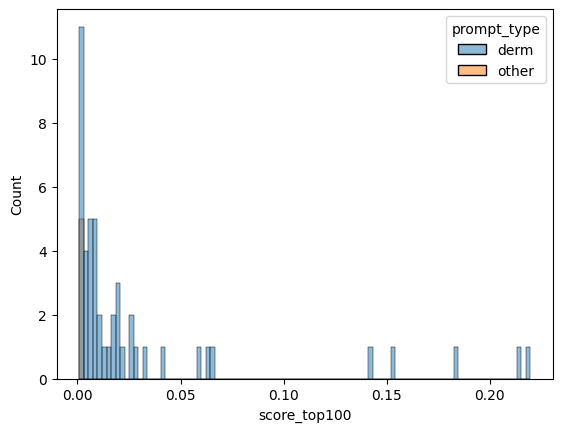

In [37]:
variable_dict["clinical_fd_clean_nodup_nooverlap"].keys()

dict_keys(['dataloader', 'image_features', 'image_features_vanilla', 'metadata_all', 'image_features_vanilla_norm', 'image_features_norm', 'valid_idx_malignant', 'valid_idx_melanoma', 'y_pos_malignant', 'y_pos_melanoma', 'concept_list', 'prompt_info_vanilla', 'prompt_info'])

In [9]:
# def calculate_similaity_score(image_features_norm, 
#                               prompt_target_embedding_norm,
#                               prompt_ref_embedding_norm,
#                               temp=1,
#                               normalize=True):

#     target_similarity=prompt_target_embedding_norm.float()@image_features_norm.T.float()
#     ref_similarity=prompt_ref_embedding_norm.float()@image_features_norm.T.float()
    
    
#     target_similarity_mean=target_similarity.mean(dim=[1])
#     ref_similarity_mean=ref_similarity.mean(axis=1)
         
#     if normalize:
#         similarity_score=scipy.special.softmax([target_similarity_mean.numpy()/temp, 
#                             ref_similarity_mean.numpy()/temp], axis=0)[0,:].mean(axis=0)   
#     else:
#         similarity_score=target_similarity_mean.mean(axis=0)

    
#     return similarity_score

In [ ]:
variable_dict.keys()

In [45]:
variable_dict["clinical_fd_clean_nodup_nooverlap"]["metadata_all"][
~variable_dict["clinical_fd_clean_nodup_nooverlap"]["metadata_all"]["skincon_Pigmented"].isnull()]\
["skincon_Pigmented"].fillna(-9).value_counts()

0.0    1713
1.0       4
Name: skincon_Pigmented, dtype: int64

# manual annotation

In [85]:
def get_concept_bool_from_metadata(dataset_name, metadata_all, concept_name):
    if "derm7pt_derm" in dataset_name:
        if concept_name=="derm7ptconcept_pigment network":
            valid_idx=(~metadata_all["pigment_network"].isnull()).values
            concept_bool=(metadata_all["pigment_network"]!="absent")
        elif concept_name=="derm7ptconcept_typical pigment network":
            valid_idx=(~metadata_all["pigment_network"].isnull()).values
#                 valid_idx=(metadata_all["pigment_network"].str.contains("typical")).values
            concept_bool=(metadata_all["pigment_network"]=="typical")
        elif concept_name=="derm7ptconcept_atypical pigment network":
            valid_idx=(~metadata_all["pigment_network"].isnull()).values
#                 valid_idx=(metadata_all["pigment_network"].str.contains("typical")).values
            concept_bool=(metadata_all["pigment_network"]=="atypical")
        elif concept_name=="derm7ptconcept_regression structure":
            valid_idx=(~metadata_all["regression_structures"].isnull()).values
            concept_bool=(metadata_all["regression_structures"]!="absent")
        elif concept_name=="derm7ptconcept_pigmentation":
            valid_idx=(~metadata_all["pigmentation"].isnull()).values
            concept_bool=(metadata_all["pigmentation"]!="absent")
        elif concept_name=="derm7ptconcept_regular pigmentation":
            valid_idx=(~metadata_all["pigmentation"].isnull()).values
#                 valid_idx=(metadata_all["pigmentation"].str.contains("regular")).values
            concept_bool=(metadata_all["pigmentation"].str.contains(" regular"))
        elif concept_name=="derm7ptconcept_irregular pigmentation":
            valid_idx=(~metadata_all["pigmentation"].isnull()).values
#                 valid_idx=(metadata_all["pigmentation"].str.contains("regular")).values
            concept_bool=(metadata_all["pigmentation"].str.contains(" irregular"))
        elif concept_name=="derm7ptconcept_blue whitish veil":
            valid_idx=(~metadata_all["blue_whitish_veil"].isnull()).values
            concept_bool=(metadata_all["blue_whitish_veil"]!="absent")
        elif concept_name=="derm7ptconcept_vascular structures":
            valid_idx=(~metadata_all["vascular_structures"].isnull()).values
            concept_bool=(metadata_all["vascular_structures"]!="absent")
        elif concept_name=="derm7ptconcept_typical vascular structures":
            valid_idx=(~metadata_all["vascular_structures"].isnull()).values
            concept_bool=(metadata_all["vascular_structures"].isin(["within regression", "arborizing", "comma", "hairpin", "wreath"]))
        elif concept_name=="derm7ptconcept_atypical vascular structures":
            valid_idx=(~metadata_all["vascular_structures"].isnull()).values
            concept_bool=(metadata_all["vascular_structures"].isin(["dotted", "linear irregular"]))
        elif concept_name=="derm7ptconcept_streaks":
            #print(metadata_all["streaks"].value_counts())
            valid_idx=(~metadata_all["streaks"].isnull()).values
            concept_bool=(metadata_all["streaks"]!="absent")
        elif concept_name=="derm7ptconcept_regular streaks":
            valid_idx=(~metadata_all["streaks"].isnull()).values
            #valid_idx=(metadata_all["streaks"].str.contains("regular")).values
            concept_bool=(metadata_all["streaks"]=="regular")
        elif concept_name=="derm7ptconcept_irregular streaks":
            valid_idx=(~metadata_all["streaks"].isnull()).values
            #valid_idx=(metadata_all["streaks"].str.contains("regular")).values
            concept_bool=(metadata_all["streaks"]=="irregular")
        elif concept_name=="derm7ptconcept_dots and globules":
            valid_idx=(~metadata_all["dots_and_globules"].isnull()).values
            concept_bool=(metadata_all["dots_and_globules"]!="absent")
        elif concept_name=="derm7ptconcept_regular dots and globules":
            valid_idx=(~metadata_all["dots_and_globules"].isnull()).values
            concept_bool=(metadata_all["dots_and_globules"]=="regular")
        elif concept_name=="derm7ptconcept_irregular dots and globules":
            valid_idx=(~metadata_all["dots_and_globules"].isnull()).values
            concept_bool=(metadata_all["dots_and_globules"]=="irregular")
        else:
            raise ValueError(concept_name)
            
        concept_bool_true=concept_bool
        concept_bool_false=(~concept_bool)


    elif "isic" in dataset_name:
        if concept_name=='isicconcept_pigment_network':
            label=(metadata_all["pigment_network"])
            valid_idx=(label!=-9).values
            concept_bool=(label>(label[valid_idx&(label>0)].quantile(0.9))).values
            concept_bool=(label>30)
        elif concept_name=='isicconcept_negative_network':
            label=(metadata_all["negative_network"])
            valid_idx=(label!=-9).values
            concept_bool=(label>(label[valid_idx&(label>0)].quantile(0.9))).values    
            concept_bool=(label>30)
        elif concept_name=='isicconcept_milia_like_cyst':
            label=(metadata_all["milia_like_cyst"])
            valid_idx=(label!=-9).values
            concept_bool=(label>(label[valid_idx&(label>0)].quantile(0.9))).values    
            concept_bool=(label>30)
        elif concept_name=='isicconcept_streaks':
            label=(metadata_all["streaks"])
            valid_idx=(label!=-9).values
            concept_bool=(label>(label[valid_idx&(label>0)].quantile(0.9))).values    
            concept_bool=(label>30)
        elif concept_name=='isicconcept_globules':
            label=(metadata_all["globules"])
            valid_idx=(label!=-9).values
            concept_bool=(label>(label[valid_idx&(label>0)].quantile(0.9))).values
            concept_bool=(label>30)
        else:
            raise ValueError(concept_name)            
            
    elif "clinical_fd_clean" in dataset_name:
        if concept_name.startswith("skincon_"):
            concept_bool_true=(metadata_all[concept_name]==1)
            concept_bool_false=(metadata_all[concept_name]==0)
        else:
            raise ValueError(concept_name)
        
      
    return {"concept_bool_true": concept_bool_true,
            "concept_bool_false": concept_bool_false,
           }

NameError: name 'dsd' is not defined

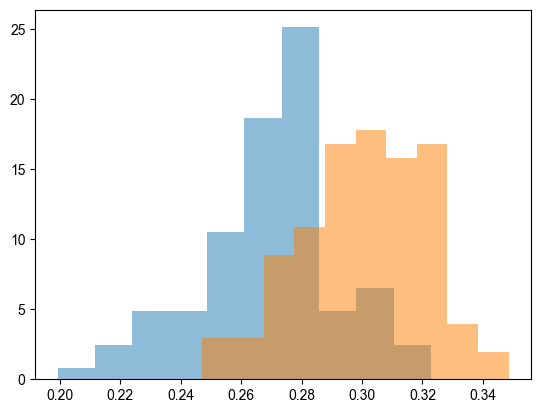

In [183]:
def temp():
    dataset_name="clinical_fd_clean_nodup_nooverlap"
    
    score_derm_list=[]
    score_other_list=[]
    
    record_list=[]
    
    #for concept_name in skincon_cols:
    for concept_name in ["skincon_Nodule"]:
#         score_derm=calculate_similaity_score(
#                     image_features_norm=variable_dict[dataset_name]["image_features_norm"],
#                     prompt_target_embedding_norm=variable_dict[dataset_name]["prompt_info"][concept_name]["prompt_target_embedding_norm"],
#                     prompt_ref_embedding_norm=variable_dict[dataset_name]["prompt_info"][concept_name]["prompt_ref_embedding_norm"],
#                     temp=1/np.exp(4.5944),
#                     ) 
        score_derm=variable_dict[dataset_name]["prompt_info"][concept_name]["prompt_target_embedding_norm"].float()@variable_dict[dataset_name]["image_features_norm"].T.float()
        score_derm=score_derm.mean(axis=[0,1]).numpy()
        
        
        concept_bool=get_concept_bool_from_metadata(dataset_name, 
                                       variable_dict[dataset_name]["metadata_all"], 
                                       concept_name)
#         concept_bool["concept_bool_true"])
        #print(concept_bool["concept_bool_false"].shape)
        #print(score_derm.shape)
#         sds

#         fig=plt.figure()
#         ax=fig.add_subplot()
#         ax.hist(score_derm, alpha=0.5, label="derm"+" "+str(np.round(np.sort(score_derm)[100],5)))
#         ax.hist(score_other, alpha=0.5, label="ches"+" "+str(np.round(np.sort(score_other)[100],5)))
#         ax.legend()
#         ax.set_title(concept_name)
#         score_derm_list.append(np.sort(score_derm)[::-1][100])
        score_derm_list+=score_derm[concept_bool["concept_bool_true"]].tolist()
    
#         print(np.sort(score_derm))
        record_list.append({"score_top100": np.sort(score_derm)[::-1][100],
                            "score_mean": np.mean(score_derm),
                           "prompt_type": "derm"
                           })    
    
    
#     for concept_name_other in ['chest_atelectasis', 'chest_cardiomegaly', 'chest_consolidation', 'chest_odema', 'chest_pleural effusion']:
    for concept_name_other in ['chest_pleural effusion']:
#         score_other=calculate_similaity_score(
#                 image_features_norm=variable_dict[dataset_name]["image_features_norm"],
#                 prompt_target_embedding_norm=variable_dict[dataset_name]["prompt_info"][concept_name_other]["prompt_target_embedding_norm"],
#                 prompt_ref_embedding_norm=variable_dict[dataset_name]["prompt_info"][concept_name_other]["prompt_ref_embedding_norm"],
#                 temp=1/np.exp(4.5944),
#                 )
        
        
#         score_derm=variable_dict[dataset_name]["prompt_info"][concept_name]["prompt_target_embedding_norm"].float()@variable_dict[dataset_name]["image_features_norm"].T.float()
#         score_derm=score_derm.mean(axis=[0,1]).numpy()        
        score_other=variable_dict[dataset_name]["prompt_info"][concept_name_other]["prompt_target_embedding_norm"].float()@variable_dict[dataset_name]["image_features_norm"].T.float()
        score_other=score_other.mean(axis=[0,1]).numpy()
    
    
#         score_other_list.append(np.sort(score_other)[::-1][100])
        
        score_other_list+=score_other[concept_bool["concept_bool_true"]].tolist()

        record_list.append({"score_top100": np.sort(score_other)[::-1][100],
                            "score_mean": np.mean(score_other),                            
                           "prompt_type": "other"
                           })        
        
#     fig=plt.figure()
#     ax=fig.add_subplot()
#     ax.hist(score_derm_list, alpha=0.5)#, label="derm"+" "+str(np.round(np.sort(score_derm)[100],5)))
#     ax.hist(score_other_list, alpha=0.5)#, label="ches"+" "+str(np.round(np.sort(score_other)[100],5)))
#     ax.legend()
#     ax.set_title(concept_name)

    fig=plt.figure()
    ax=fig.add_subplot()
    
    ax.hist(score_other_list, density=True, alpha=0.5)
    ax.hist(score_derm_list, density=True, alpha=0.5)
    
    
    dsd
    sns.histplot(x="score_top100", hue="prompt_type", bins=100, data=pd.DataFrame(record_list), ax=ax)
    
    print(pd.DataFrame(record_list).groupby("prompt_type")["score_top100"].apply(
        lambda x: 
            {"mean": x.mean(),
              "std": x.std(),
              "max": x.max(),
              "q3": x.quantile(q=0.75),                                                                      
              "median": x.median(),
              "q1": x.quantile(q=0.25),
              "min": x.min(),  
            }
        )
    )
    
    print(pd.DataFrame(record_list).groupby("prompt_type")["score_mean"].apply(
        lambda x: 
            {"mean": x.mean(),
              "std": x.std(),
              "max": x.max(),
              "q3": x.quantile(q=0.75),                                                                      
              "median": x.median(),
              "q1": x.quantile(q=0.25),
              "min": x.min(),  
            }
        )
    )    
         
    fig=plt.figure()
    ax=fig.add_subplot()         
    ax.hist(score_derm_list, alpha=0.5)#, label="derm"+" "+str(np.round(np.sort(score_derm)[100],5)))
    ax.hist(score_other_list, alpha=0.5)#, label="ches"+" "+str(np.round(np.sort(score_other)[100],5)))
    ax.legend()
    ax.set_title(concept_name)
    
temp()


NameError: name 'data' is not defined

11 1624
851 784
26 1609
699 936
0 1635
34 1601
7 1628
37 1598
100 1535
60 1575
212 1423
76 1559
12 1623
21 1614
51 1584
2 1633
8 1627
4 1631
4 1631
46 1589
302 1333
35 1600
60 1575
5 1630
17 1618
20 1615
32 1603
134 1501
8 1627
614 1021


/homes/gws/chanwkim/miniconda3/envs/MONET/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/gws/chanwkim/miniconda3/envs/MONET/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


17 1618
112 1523
19 1616
102 1533
76 1559
893 742
10 1625
3 1632
2 1633
31 1604
1 1634
6 1629
7 1628
2 1633
0 1635
0 1635
4 1631
4 1631
AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)
                                      concept_name_other  num_pos  \
concept_name                                                        
skincon_Papule                    chest_pleural effusion      851   
skincon_Plaque                    chest_pleural effusion      699   
skincon_Pustule                   chest_pleural effusion       34   
skincon_Patch                     chest_pleural effusion       37   
skincon_Nodule                    chest_pleural effusion      100   
skincon_Ulcer                     chest_pleural effusion       60   
skincon_Crust                     chest_pleural effusion      212   
skincon_Erosion                   chest_pleural effusion       76   
skincon_Exudate                   chest_pleural effusion       51   
skincon_Telangiectasia            c

/homes/gws/chanwkim/miniconda3/envs/MONET/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/homes/gws/chanwkim/miniconda3/envs/MONET/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/homes/gws/chanwkim/miniconda3/envs/MONET/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/tmp/ipykernel_102561/2427899677.py:11: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' i

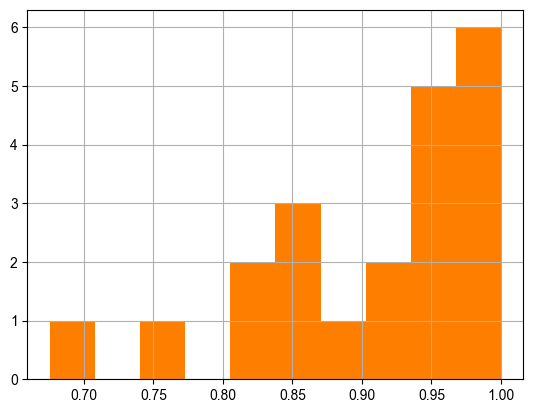

In [278]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    print(se,scipy.stats.t.ppf((1 + confidence) / 2., n-1))
    return m, m-h, m+h

def mean_confidence_interval2(data, confidence=0.95):

    return scipy.stats.t.interval(alpha=confidence, df=len(data)-1, loc=np.mean(data), scale=scipy.stats.sem(data)) 

def temp():
    dataset_name="clinical_fd_clean_nodup_nooverlap"
    
    score_derm_list=[]
    score_other_list=[]
    
    record_list=[]
    
    for concept_name in skincon_cols:
#         score_derm=calculate_similaity_score(
#                     image_features_norm=variable_dict[dataset_name]["image_features_norm"],
#                     prompt_target_embedding_norm=variable_dict[dataset_name]["prompt_info"][concept_name]["prompt_target_embedding_norm"],
#                     prompt_ref_embedding_norm=variable_dict[dataset_name]["prompt_info"][concept_name]["prompt_ref_embedding_norm"],
#                     temp=1/np.exp(4.5944),
#                     )  
        
        score_derm=variable_dict[dataset_name]["prompt_info"][concept_name]["prompt_target_embedding_norm"].float()@variable_dict[dataset_name]["image_features_norm"].T.float()
        score_derm=score_derm.mean(axis=[0,1]).numpy()                
        
        
        concept_bool=get_concept_bool_from_metadata(dataset_name, 
                                       variable_dict[dataset_name]["metadata_all"], 
                                       concept_name)
    
        
        sample_idx=concept_bool["concept_bool_true"]&variable_dict[dataset_name]["valid_idx_malignant"]
        sample_non_idx=concept_bool["concept_bool_false"]&variable_dict[dataset_name]["valid_idx_malignant"]
        sample_all=variable_dict[dataset_name]["valid_idx_malignant"]
        print(sample_idx.sum(), sample_non_idx.sum())
        #print(concept_name, sample_idx.sum())
        
#         for concept_name_other in ['chest_atelectasis', 'chest_cardiomegaly', 'chest_consolidation', 'chest_odema', 'chest_pleural effusion']:
        for concept_name_other in ['chest_pleural effusion']:
#             score_other=calculate_similaity_score(
#                     image_features_norm=variable_dict[dataset_name]["image_features_norm"],
#                     prompt_target_embedding_norm=variable_dict[dataset_name]["prompt_info"][concept_name_other]["prompt_target_embedding_norm"],
#                     prompt_ref_embedding_norm=variable_dict[dataset_name]["prompt_info"][concept_name_other]["prompt_ref_embedding_norm"],
#                     temp=1/np.exp(4.5944),
#                     )   
            

            score_other=variable_dict[dataset_name]["prompt_info"][concept_name_other]["prompt_target_embedding_norm"].float()@variable_dict[dataset_name]["image_features_norm"].T.float()
            score_other=score_other.mean(axis=[0,1]).numpy()            
            
            score_other_ref=variable_dict[dataset_name]["prompt_info"][concept_name_other]["prompt_ref_embedding_norm"].float()@variable_dict[dataset_name]["image_features_norm"].T.float()
            score_other_ref=score_other_ref.mean(axis=[0,1]).numpy()                        

            record_list.append(
            
            {
                "concept_name": concept_name,
                "concept_name_other":concept_name_other,
                "num_pos": sample_idx.sum(),
                "prop_larger_pos": np.mean((score_derm[sample_idx]-score_other[sample_idx])>0),
                "pval_larger_pos": scipy.stats.ttest_rel(score_derm[sample_idx], score_other[sample_idx], alternative='greater')[1],
                "prop_larger_neg": np.mean((score_derm[sample_non_idx]-score_other[sample_non_idx])>0),
                "pval_larger_neg": scipy.stats.ttest_rel(score_derm[sample_non_idx], score_other[sample_non_idx], alternative='greater')[1],
                "prop_larger_all": np.mean((score_derm[sample_all]-score_other[sample_all])>0),
                "pval_larger_all": scipy.stats.ttest_rel(score_derm[sample_all], score_other[sample_all], alternative='greater')[1],                
                "prop_larger_ref": np.mean((score_derm[sample_idx]-score_other_ref[sample_idx])>0)
            }
            )
            #print(concept_name, score_other[sample_idx].mean())
            
        #print()
        
    record_list_df=pd.DataFrame(record_list).set_index("concept_name")
    
    
    
    print((record_list_df[record_list_df["num_pos"]>=30]["prop_larger_pos"].hist()))
    print((record_list_df[record_list_df["num_pos"]>=30]["prop_larger_pos"].hist()))
    print(record_list_df[record_list_df["num_pos"]>=30])
    
    print("larger_pos")
    print(mean_confidence_interval2(record_list_df[record_list_df["num_pos"]>=30]["prop_larger_pos"]),
          "prop mean", record_list_df[record_list_df["num_pos"]>=30]["prop_larger_pos"].mean(),
          "prop std", record_list_df[record_list_df["num_pos"]>=30]["prop_larger_pos"].std(),
          "prop max", record_list_df[record_list_df["num_pos"]>=30]["prop_larger_pos"].max(),
          "prop min", record_list_df[record_list_df["num_pos"]>=30]["prop_larger_pos"].min(),
          mean_confidence_interval2(record_list_df[record_list_df["num_pos"]>=30]["pval_larger_pos"]),
          "pval mean", record_list_df[record_list_df["num_pos"]>=30]["pval_larger_pos"].mean(),
          "pval median", record_list_df[record_list_df["num_pos"]>=30]["pval_larger_neg"].median(),
          "pval std", record_list_df[record_list_df["num_pos"]>=30]["pval_larger_pos"].std(),
          "pval max", record_list_df[record_list_df["num_pos"]>=30]["pval_larger_pos"].max(),
          "pval min", record_list_df[record_list_df["num_pos"]>=30]["pval_larger_pos"].min()          
         )
    
#     print("larger_neg")
#     print(mean_confidence_interval2(record_list_df[record_list_df["num_pos"]>=30]["prop_larger_neg"]),
#           record_list_df[record_list_df["num_pos"]>=30]["prop_larger_neg"].mean(),
#           record_list_df[record_list_df["num_pos"]>=30]["prop_larger_neg"].std(),
#           mean_confidence_interval2(record_list_df[record_list_df["num_pos"]>=30]["pval_larger_neg"]),
#           "pval mean", record_list_df[record_list_df["num_pos"]>=30]["pval_larger_neg"].mean(),
#           "pval median", record_list_df[record_list_df["num_pos"]>=30]["pval_larger_neg"].median(),
#           "pval std", record_list_df[record_list_df["num_pos"]>=30]["pval_larger_neg"].std()
#          )
    
    print("larger_all")
    print(mean_confidence_interval2(record_list_df[record_list_df["num_pos"]>=30]["prop_larger_all"]),
          "prop mean", record_list_df[record_list_df["num_pos"]>=30]["prop_larger_all"].mean(),
          "prop std", record_list_df[record_list_df["num_pos"]>=30]["prop_larger_all"].std(),
          "prop max", record_list_df[record_list_df["num_pos"]>=30]["prop_larger_all"].max(),
          "prop min", record_list_df[record_list_df["num_pos"]>=30]["prop_larger_all"].min(),
          mean_confidence_interval2(record_list_df[record_list_df["num_pos"]>=30]["pval_larger_all"]),
          "pval mean", record_list_df[record_list_df["num_pos"]>=30]["pval_larger_all"].mean(),
          "pval median", record_list_df[record_list_df["num_pos"]>=30]["pval_larger_all"].median(),
          "pval std", record_list_df[record_list_df["num_pos"]>=30]["pval_larger_all"].std(),
          "pval max", record_list_df[record_list_df["num_pos"]>=30]["pval_larger_all"].max(),
          "pval min", record_list_df[record_list_df["num_pos"]>=30]["pval_larger_all"].min()
         )    
    
    
        
temp()

In [296]:
0.00034191898671290515*21

0.0071802987209710085

In [295]:
1.4730998132949117e-19*21

3.0935096079193147e-18

In [282]:
from scipy import stats

In [290]:
from statsmodels.stats import multitest


# .multipletests

In [294]:
multitest.multipletests([0.01,0.02, 0.05, 0.067], method="bonferroni")

(array([ True, False, False, False]),
 array([0.04 , 0.08 , 0.2  , 0.268]),
 0.012741455098566168,
 0.0125)

In [283]:
stats.

AttributeError: module 'scipy.stats' has no attribute 'false_discovery_control'

In [246]:
data_audit_loaded=torch.load("logs/experiment_results/concept_annotation_data_auditing_0930.pt", map_location="cpu")

In [249]:
compare_manaul_0930=torch.load("logs/experiment_results/compare_manaul_0930.pt", map_location="cpu")

In [248]:
data_audit_loaded["clinical_fd_clean_nodup_nooverlap"].keys()

dict_keys(['dataloader', 'image_features', 'metadata_all', 'valid_idx', 'y_pos', 'concept_list', 'image_features_norm', 'prompt_info', 'subset_concept_presense', 'concept_diff_sole', 'concept_diff_cross'])

In [251]:
compare_manaul_0930["clinical_fd_clean_nodup_nooverlap"].keys()

dict_keys(['dataloader', 'image_features', 'image_features_vanilla', 'metadata_all', 'valid_idx', 'concept_list', 'image_features_vanilla_norm', 'image_features_norm', 'prompt_info_vanilla', 'prompt_info', 'disease_eval', 'skintone_eval', 'concept_eval'])

In [254]:
compare_manaul_0930["clinical_fd_clean_nodup_nooverlap"]["concept_eval"]

[{'manual_automatic': 'automatic',
  'group_key': 'all',
  'trained': 'MONET',
  'concept_name': 'skincon_Papule',
  'num_test': 1635,
  'num_test_pos': 851,
  'num_test_neg': 784,
  'auc': 0.710546116213818},
 {'manual_automatic': 'automatic',
  'group_key': '12',
  'trained': 'MONET',
  'concept_name': 'skincon_Papule',
  'num_test': 708,
  'num_test_pos': 364,
  'num_test_neg': 344,
  'auc': 0.6831075900843343},
 {'manual_automatic': 'automatic',
  'group_key': '34',
  'trained': 'MONET',
  'concept_name': 'skincon_Papule',
  'num_test': 606,
  'num_test_pos': 339,
  'num_test_neg': 267,
  'auc': 0.7270447339056267},
 {'manual_automatic': 'automatic',
  'group_key': '56',
  'trained': 'MONET',
  'concept_name': 'skincon_Papule',
  'num_test': 283,
  'num_test_pos': 137,
  'num_test_neg': 146,
  'auc': 0.7524747525247475},
 {'manual_automatic': 'automatic',
  'group_key': 'all',
  'trained': 'vanilla',
  'concept_name': 'skincon_Papule',
  'num_test': 1635,
  'num_test_pos': 851,
  '

In [253]:
compare_manaul_0930["clinical_fd_clean_nodup_nooverlap"]["skintone_eval"]

[{'manual_automatic': 'automatic',
  'group_key': 'all',
  'trained': 'MONET',
  'concept_name': 'skintone_dark',
  'num_test': 4730,
  'num_test_pos': 560,
  'num_test_neg': 4170,
  'auc': 0.8051199040767387},
 {'manual_automatic': 'automatic',
  'group_key': 'all',
  'trained': 'vanilla',
  'concept_name': 'skintone_dark',
  'num_test': 4730,
  'num_test_pos': 560,
  'num_test_neg': 4170,
  'auc': 0.7356119390202124},
 {'manual_automatic': 'manual',
  'group_key': 'all',
  'concept_name': 'skintone_dark',
  'random_seed': 0,
  'num_train': 3784,
  'num_train_pos': 436,
  'num_train_neg': 3348,
  'num_test': 946,
  'num_test_pos': 124,
  'num_test_neg': 822,
  'auc': 0.8598226198885488},
 {'manual_automatic': 'manual',
  'group_key': 'all',
  'concept_name': 'skintone_dark',
  'random_seed': 1,
  'num_train': 3784,
  'num_train_pos': 460,
  'num_train_neg': 3324,
  'num_test': 946,
  'num_test_pos': 100,
  'num_test_neg': 846,
  'auc': 0.9162293144208038},
 {'manual_automatic': 'manua

In [ ]:
1635

In [232]:
get_concept_bool_from_metadata??

In [231]:
26+1691

1717

In [ ]:
import clip

In [ ]:
model, preprocess = clip.load('ViT-B/32', device)

In [ ]:
0.863+0.105

In [239]:
variable_dict["clinical_fd_clean_nodup_nooverlap"]["valid_idx_malignant"].shape

(4992,)

In [237]:
variable_dict["clinical_fd_clean_nodup_nooverlap"]["valid_idx_malignant"].sum()

4910

In [236]:
variable_dict["clinical_fd_clean_nodup_nooverlap"].keys()

dict_keys(['dataloader', 'image_features', 'image_features_vanilla', 'metadata_all', 'image_features_vanilla_norm', 'image_features_norm', 'valid_idx_malignant', 'valid_idx_melanoma', 'y_pos_malignant', 'y_pos_melanoma', 'concept_list', 'prompt_info_vanilla', 'prompt_info'])

In [210]:
0.8639559576+1.96*0.022826282925137

0.9086954721332685

In [209]:
0.10460316933/np.sqrt(21)

0.022826282923190864

In [190]:
pd.Series([1, 2, 3]).sem()

0.5773502691896258